# Figure 3

This figure shows that mBGP avoids cell assignment inconsistencies.
MMBGP is essentially the same as BGP at learning BPs.


# Helper definitions

In [1]:
from MMBGP.data_generation import ToyBranchedData, GeneExpressionData
from MMBGP.training_helpers import TrainingOutcome, get_training_outcome
from MMBGP.plotting_helpers import plot_detailed_fit, plot_model_snapshot
from MMBGP.sampling_helpers import get_synthetic_noisy_branched_data

from MMBGP.assigngp import AssignGP
from MMBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np

from MMBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow
from typing import Sequence


def get_assigngp_with_target_bps(bps: Sequence[float], lengthscale: float, noise_variance: float) -> AssignGP:
    """ A simple wrapper that tweaks some key model construction parameters. """
    data = ToyBranchedData(bps, N=100)  # not used; need data to construct a model
    m = construct_assigngp_model(
        gene_expression=data,
        phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
        initial_branching_points=[0.5]*data.num_genes,
    )
    
    # assign reasonable initial values for the BPs
    m.kernel.Bv.assign(np.array(bps))
    m.kernel.kern.lengthscales.assign(lengthscale)
    m.likelihood.variance.assign(noise_variance)
    return m

In [2]:
from MMBGP.data_generation import Vector
from MMBGP.training_helpers import InitialAndPriorPhi, PhiConstructor


def get_funky_phi(
        global_branching_state: Vector,
        uninformative_until: float,
        informative_prior_confidence: float,
) -> InitialAndPriorPhi:
    if not 0 <= uninformative_until <= 1:
        raise ValueError(
            f"Expected uninformative_until to be in the range [0, 1]. "
            f"Instead got: {uninformative_until}."
        )
    if not 0 <= informative_prior_confidence <= 1:
        raise ValueError(
            f"Expected informative_prior_confidence to be in the range [0, 1]. "
            f"Instead got: {uninformative_until}."
        )

    (N,) = global_branching_state.shape
    # WARNING: assumes uniformly spaced state on [0, 1].
    uninformative_until_idx = int(uninformative_until * N)
    print(f"Uninformative until idx: {uninformative_until_idx}")

    # Initialise phi_initial and phi_prior to 50% probability for each of the branches g, h
    # We will then update them
    phi_initial = np.ones((N, 2)) * 0.5
    phi_prior = np.ones((N, 2)) * 0.5

    # TODO: the following can probably be written as pure numpy array operations,
    #   but we're taking the easy way for speed.
    for i in range(N):
        not_trunk = global_branching_state[i] in {2, 3}

        if not_trunk:
            # The g, h states normally map to 2, 3, but here we want to map them to columns 0, 1
            true_branch_col = int(global_branching_state[i] - 2)
            if i > uninformative_until_idx:
                phi_prior[i, :] = 1 - informative_prior_confidence
                phi_prior[i, true_branch_col] = informative_prior_confidence
            # else leave at 0.5, 0.5

            # Set phi_initial to have true state label with a random probability in [0.5, 1]
            # This is the same as SimplePhiConstructor
            phi_initial[i, true_branch_col] = 0.5 + (np.random.random() / 2.)
            phi_initial[i, true_branch_col != np.array([0, 1])] = 1 - phi_initial[i, true_branch_col]

    assert np.allclose(phi_prior.sum(1), 1), \
        f"Phi Prior probability distribution should sum to 1 for each branch. " \
        f"Instead got: {phi_prior.sum(1)}"
    assert np.allclose(phi_initial.sum(1), 1), \
        f"Phi Initial probability distribution should sum to 1 for each branch. " \
        f"Instead got: {phi_initial.sum(1)}"
    assert np.all(~np.isnan(phi_initial)), f"Found NaNs in phi_initial, something has gone badly wrong!"
    assert np.all(~np.isnan(phi_prior)), f"Found NaNs in phi_prior, something has gone badly wrong!"
    return phi_initial, phi_prior


class FunkyPrior(PhiConstructor):
    """
    Uninformative prior for early cells, informative prior for late cells.
    """

    def __init__(
            self,
            gene_expression_data: GeneExpressionData,
            uninformative_until: float,
            informative_prior_confidence: float,
            allow_infs: bool = True,
    ) -> None:
        self._state = gene_expression_data.state
        self._uninformative_until = uninformative_until
        self._informative_prior_confidence = informative_prior_confidence
        self._allow_infs = allow_infs

    def build(self) -> InitialAndPriorPhi:
        phi_initial, phi_prior = get_funky_phi(
            global_branching_state=self._state,
            uninformative_until=self._uninformative_until,
            informative_prior_confidence=self._informative_prior_confidence,
        )

        phi_prior = np.c_[np.zeros(phi_prior.shape[0])[:, None], phi_prior]  # prepend 0 for trunk
        return phi_initial, phi_prior

In [3]:
def count_branch_inconsistencies(
        models: Sequence[AssignGP], 
        threshold: float, 
        debug: bool = False,
        only_branches: bool = True,
) -> int:
    """ 
    Count how many cell assignments to branches g, h are inconsistent across genes. 
    
    What do we mean by inconsistent cell assignments to branches g, h?
    Set n = 0.
    Iterate over all cells.
    For each cell, iterate over all models.
    We say that a model has strong belief about cell assignment 
    to branches g, h if either probability in Phi is above :param:`threshold`.
    Compare all models with strong beliefs.
    If they all agree on the cell assignment, then we don't increment n.
    Otherwise increment n.
    """
    n = 0
    num_cells = models[0].N
    
    # only keep the bits of Phi that correspond to g and h
    all_phis_projected = [m.GetPhi()[:, 1:] for m in models]
    all_bps = [m.BranchingPoints[0] for m in models]

    for i in range(num_cells):
        # Here we're assuming X is uniformly spaced across [0, 1].
        cell_pseudotime = i/num_cells
        
        strong_opinions = [phi[i] > threshold for phi in all_phis_projected]
        
        # we only consider strong opinions if they are after the model's indicated branching point
        valid_strong_opinions = []
        for j, opinion in enumerate(strong_opinions):
            if opinion.any():
                if only_branches:
                    # only keep data past the branching point
                    if cell_pseudotime > all_bps[j]:
                        valid_strong_opinions.append(opinion)
                else:
                    valid_strong_opinions.append(opinion)
        
        # We now multiply all the valid strong opinions together.
        # If they disagree, we're left with np.array([0, 0]), otherwise we get
        # either np.array([1, 0]) or np.array([0, 1]).
        # We discern the situation via .sum()
        strong_opinions_agree = bool(np.multiply.reduce(valid_strong_opinions).sum())
        
        if not strong_opinions_agree:
            n += 1
            if debug:
                print(
                    f"phis: {[phi[i] for phi in all_phis_projected]}, "
                    f"valid_strong_opinions: {valid_strong_opinions}"
                )
    
    return n

In [4]:
from typing import Set


def get_correct_label_idx_bgp(model: AssignGP, data: GeneExpressionData, true_bp: float) -> Set[int]:
    """
    Get idx of the cells with correct labels.
    
    We're working around the fact that the sliced data labels
    don't reflect the branching point locations.
    """
    num_cells = model.N
    assert num_cells == data.t.shape[0]
    assert data.Y.shape[1] == 1, (
        f"BGP should be fit on single dimensional outputs, instead got {data.Y.shape[1]}"
    )
    
    true_bp_idx = int(true_bp * num_cells)  # assumes pseudotime on [0, 1]
    learned_bp_idx = int(model.BranchingPoints[0] * num_cells)
    
    phi = model.GetPhi()
    
    correct_labels = set()
    for i in range(num_cells):
        # recall that 1 is for trunk
        true_label = 1 if i < true_bp_idx else data.state[i]  # 1, 2 or 3
        
        if i < learned_bp_idx:
            inferred_label = 1  # trunk
        else:
            inferred_label_idx = np.argmax(phi[i]) # 0, 1 or 2
            inferred_label = inferred_label_idx + 1
        
        if inferred_label == true_label:
            correct_labels.add(i)
        
    return correct_labels

In [5]:
def get_correct_label_idx_mmbgp(model: AssignGP, data: GeneExpressionData, true_bps: Sequence[float]) -> Set[int]:
    """
    Count how many labels are correct. 
    Return a set of indices, one for each gene.
    """
    num_cells = model.N
    bps = model.BranchingPoints
    
    num_genes = bps.size
    
    assert num_cells == data.t.shape[0]
    assert num_genes == data.Y.shape[1], (
        f"MMBGP not fit on this data, different output dimensions: {num_genes} vs {data.Y.shape[1]}"
    )
    
    correct_idxs: List[Set[int]] = []
    
    for i in range(num_genes):
        true_bp_idx = int(true_bps[i] * num_cells)  # assumes pseudotime on [0, 1]
        learned_bp_idx = int(bps[i] * num_cells)
    
        phi = model.GetPhi()
    
        correct_labels = set()
        for i in range(num_cells):
            # recall that 1 is for trunk
            true_label = 1 if i < true_bp_idx else data.state[i]  # 1, 2 or 3
        
            if i < learned_bp_idx:
                inferred_label = 1  # trunk
            else:
                inferred_label_idx = np.argmax(phi[i]) # 0, 1 or 2
                inferred_label = inferred_label_idx + 1
        
            if inferred_label == true_label:
                correct_labels.add(i)
        
        correct_idxs.append(correct_labels)
        
    return correct_idxs

In [6]:
import numpy as np
import pandas as pd


from dataclasses import dataclass
from typing import List


@dataclass
class Result:
    data: GeneExpressionData  # the data we have attempted to fit models to
    true_bps: np.ndarray  # true branching points
    mmbgp: AssignGP  # the trained MMBGP model for the provided data
    bgps: Sequence[AssignGP]  # the trained BGP models for the provided data


def rmse(a: np.ndarray, b: np.ndarray) -> float:
    assert a.shape == b.shape
    n = a.shape[0]
    return np.sqrt(((a - b)**2).mean())


def convert_results_to_df(res: Sequence[Result], inconsistency_threshold: float = 0.8) -> pd.DataFrame:
    dictified_results = []
    
    for i, r in enumerate(res):
        dres = dict(
            sample_id=i,
            mmbgp_bp_rmse=rmse(r.true_bps, r.mmbgp.BranchingPoints),
            bgp_bp_rmse=rmse(r.true_bps, np.array([bgp.BranchingPoints[0] for bgp in r.bgps])),
            inconsistent_branches=count_branch_inconsistencies(r.bgps, inconsistency_threshold),
            inconsistent_all=count_branch_inconsistencies(r.bgps, inconsistency_threshold, only_branches=False),
            mean_mmbgp_correct_labels=np.array([
                len(correct_labels) for correct_labels in get_correct_label_idx_mmbgp(r.mmbgp, r.data, TRUE_BPS)
            ]).mean(),
        )
        
        bgp_correct_labels = []
        for j, bgp in enumerate(r.bgps):
            sliced_data = GeneExpressionData(
                t=r.data.t,
                Y=r.data.Y[:, j].reshape(-1, 1),
                state=r.data.state,
                gene_labels=[f"{j}"]
            )
            correct_labels = get_correct_label_idx_bgp(bgp, sliced_data, TRUE_BPS[j])
            bgp_correct_labels.append(correct_labels)
            
            
        dres["mean_bgp_correct_labels"] = np.array([len(cl) for cl in bgp_correct_labels]).mean()
        
        dictified_results.append(dres)
    
    return pd.DataFrame(dictified_results)

In [16]:
from typing import Tuple


def convert_result_to_incorrect_label_count(
        res: Result,
) -> Tuple[Sequence[int], Sequence[int]]:
    """ 
    Given a sequence of results, produce two sequences of incorrect cell label pseudotimes:
    one for MMBGP and one for BGP.
    """    
    # Get the number of data points for idx to pseudotime conversions
    n = res.data.t.size
    
    mmbgp_correct_labels = get_correct_label_idx_mmbgp(res.mmbgp, res.data, TRUE_BPS)
    # This is a list of sets with each set corresponding to the indices with correct labels,
    # for example {1, 3, 10, ..., 99}. 
    # We now invert each set to get its complement in {0, 1, 2, 3, ..., 99}
    mmbgp_incorrect_labels = [
        set(range(n)) - set(correct_labels_per_gene) 
        for correct_labels_per_gene in mmbgp_correct_labels
    ]
    # Now flatten the sets into one long list and convert idx to pseudotime
    mmbgp_incorrect_pseudotimes = [
        i/n
        for incorrect_labels_per_gene in mmbgp_incorrect_labels
        for i in incorrect_labels_per_gene
    ]

    bgp_incorrect_labels = []
    for j, bgp in enumerate(res.bgps):
        sliced_data = GeneExpressionData(
            t=res.data.t,
            Y=res.data.Y[:, j].reshape(-1, 1),
            state=res.data.state,
            gene_labels=[f"{j}"]
        )
        correct_labels = get_correct_label_idx_bgp(bgp, sliced_data, TRUE_BPS[j])
        # This is a set of form {1, 3, 10, ..., 99}. 
        # We now invert it to get the complement of the above set in {0, 1, 2, 3, ..., 99}
        incorrect_labels = set(range(n)) - correct_labels
        
        bgp_incorrect_labels.append(incorrect_labels)
    
    # Now convert to pseudotimes by dividing through the number of data points
    bgp_incorrect_pseudotimes = [
        i/n
        for bgp_incorrect_labels_per_gene in bgp_incorrect_labels
        for i in bgp_incorrect_labels_per_gene
    ]
    
    return (mmbgp_incorrect_pseudotimes, bgp_incorrect_pseudotimes)

In [17]:
import seaborn as sns


def plot_incorrect_label_histograms(results: Sequence[Result]) -> None:
    mmbgp_all, bgp_all = [], []

    for i, res in enumerate(results): 
        mbgp_incorrect_ptime, bgp_incorrect_ptime = convert_result_to_incorrect_label_count(res)
    
        fig, axa = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
        axa[0].hist(mbgp_incorrect_ptime)
        axa[0].set_title(f"Sample {i}, MMBGP incorrect labels")
        axa[1].hist(bgp_incorrect_ptime)
        axa[1].set_title(f"Sample {i}, BGP incorrect labels")
        plt.show()

        mmbgp_all.extend(mbgp_incorrect_ptime)
        bgp_all.extend(bgp_incorrect_ptime)


    fig, axa = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    
    sns.histplot(mmbgp_all, bins=20, ax=axa[0])
    axa[0].set_title("All MMBGP incorrect labels")
    sns.histplot(bgp_all, bins=20, ax=axa[1])
    axa[1].set_title("All BGP incorrect labels")
    plt.savefig("experiments-figure-3-bgp-label-inconsistency")

## MMBGP vs BGP incorrect label histograms

Using the funky prior.

Processing sample 0
Uninformative until idx: 80


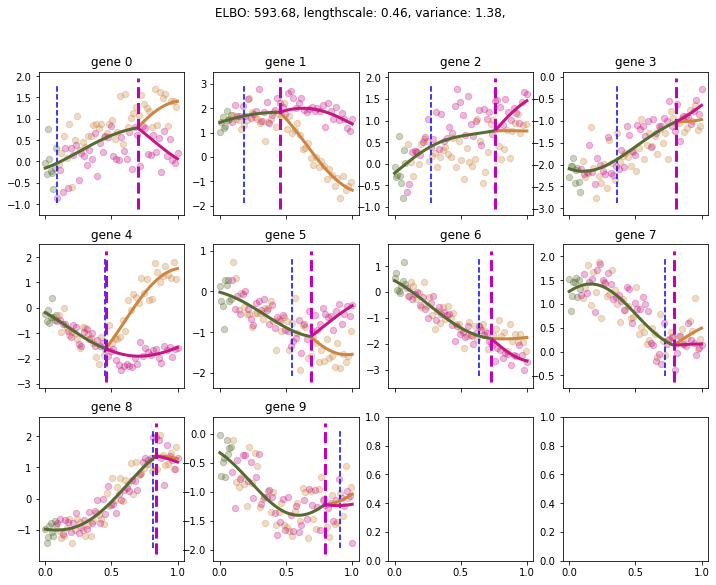

Slicing for gene 0
Uninformative until idx: 80


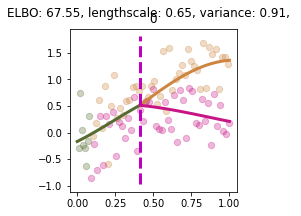

Slicing for gene 1
Uninformative until idx: 80


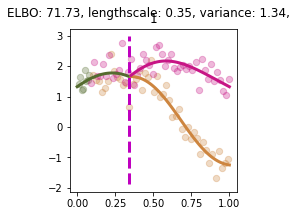

Slicing for gene 2
Uninformative until idx: 80


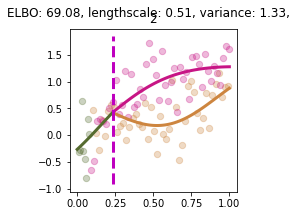

Slicing for gene 3
Uninformative until idx: 80


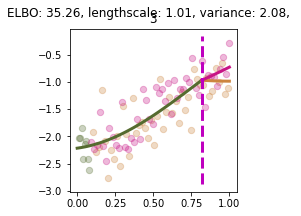

Slicing for gene 4
Uninformative until idx: 80


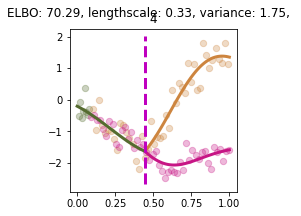

Slicing for gene 5
Uninformative until idx: 80


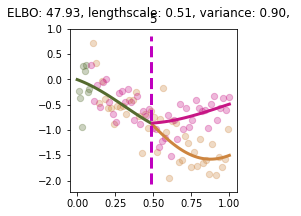

Slicing for gene 6
Uninformative until idx: 80


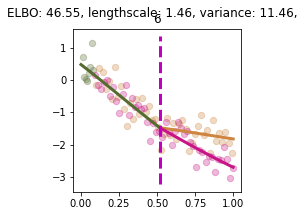

Slicing for gene 7
Uninformative until idx: 80


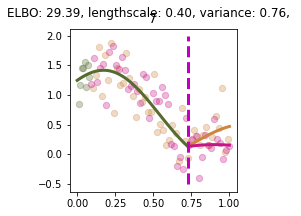

Slicing for gene 8
Uninformative until idx: 80


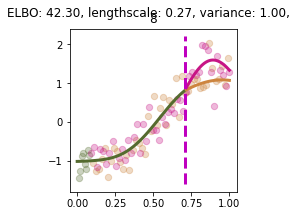

Slicing for gene 9
Uninformative until idx: 80


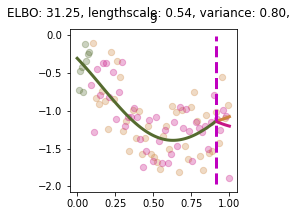

Processing sample 1
Uninformative until idx: 80


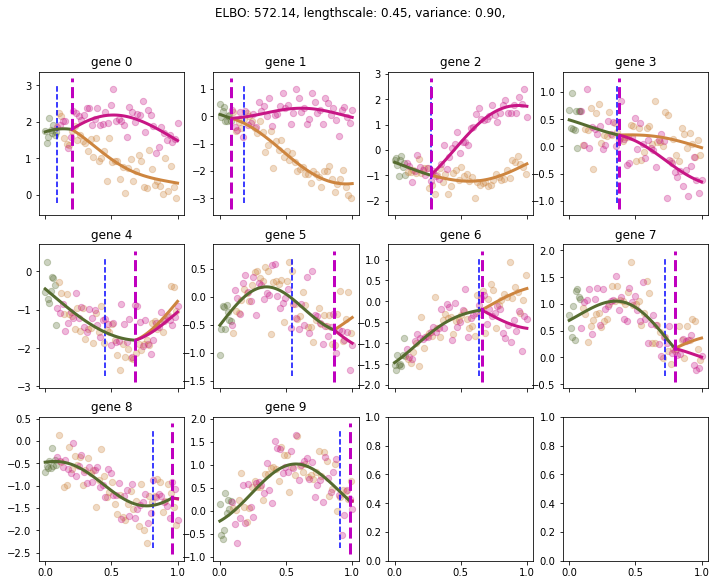

Slicing for gene 0
Uninformative until idx: 80


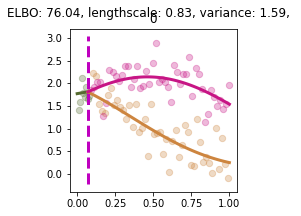

Slicing for gene 1
Uninformative until idx: 80


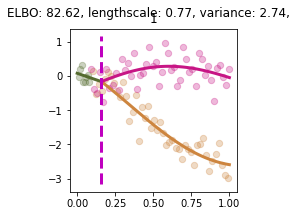

Slicing for gene 2
Uninformative until idx: 80


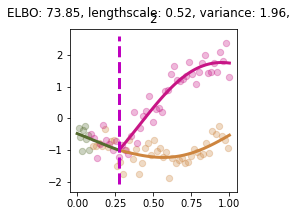

Slicing for gene 3
Uninformative until idx: 80


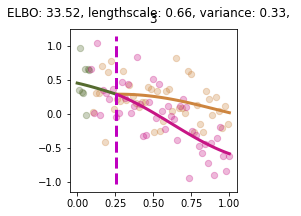

Slicing for gene 4
Uninformative until idx: 80


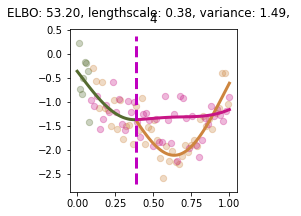

Slicing for gene 5
Uninformative until idx: 80


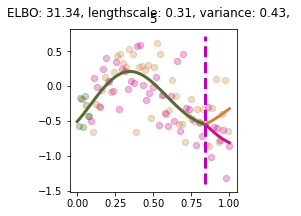

Slicing for gene 6
Uninformative until idx: 80


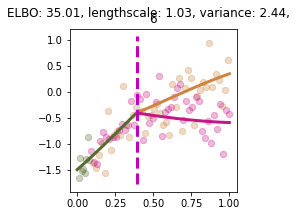

Slicing for gene 7
Uninformative until idx: 80


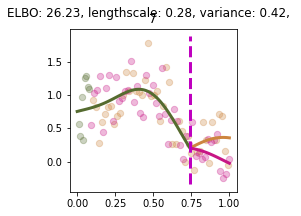

Slicing for gene 8
Uninformative until idx: 80


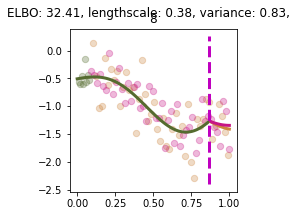

Slicing for gene 9
Uninformative until idx: 80


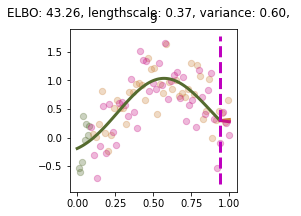

Processing sample 2
Uninformative until idx: 80


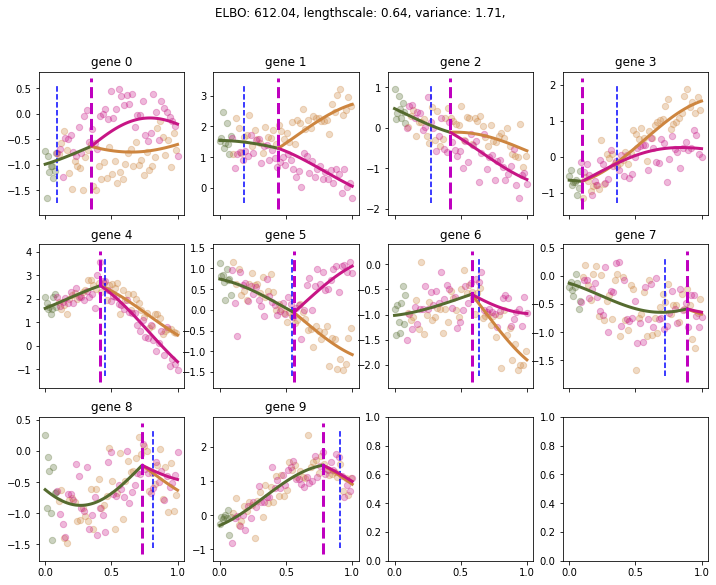

Slicing for gene 0
Uninformative until idx: 80


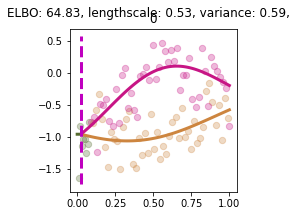

Slicing for gene 1
Uninformative until idx: 80


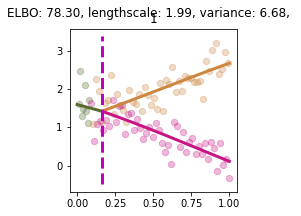

Slicing for gene 2
Uninformative until idx: 80


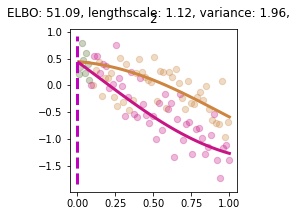

Slicing for gene 3
Uninformative until idx: 80


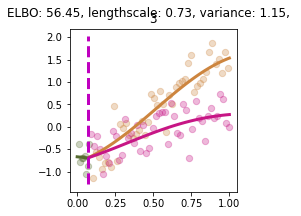

Slicing for gene 4
Uninformative until idx: 80


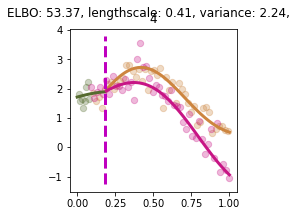

Slicing for gene 5
Uninformative until idx: 80


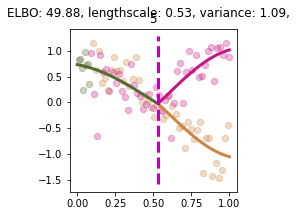

Slicing for gene 6
Uninformative until idx: 80


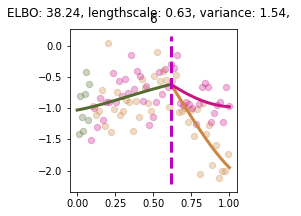

Slicing for gene 7
Uninformative until idx: 80


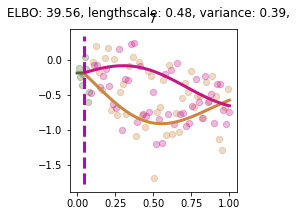

Slicing for gene 8
Uninformative until idx: 80


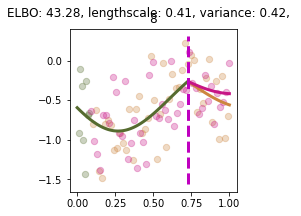

Slicing for gene 9
Uninformative until idx: 80


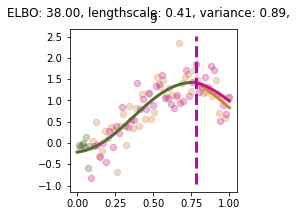

Processing sample 3
Uninformative until idx: 80


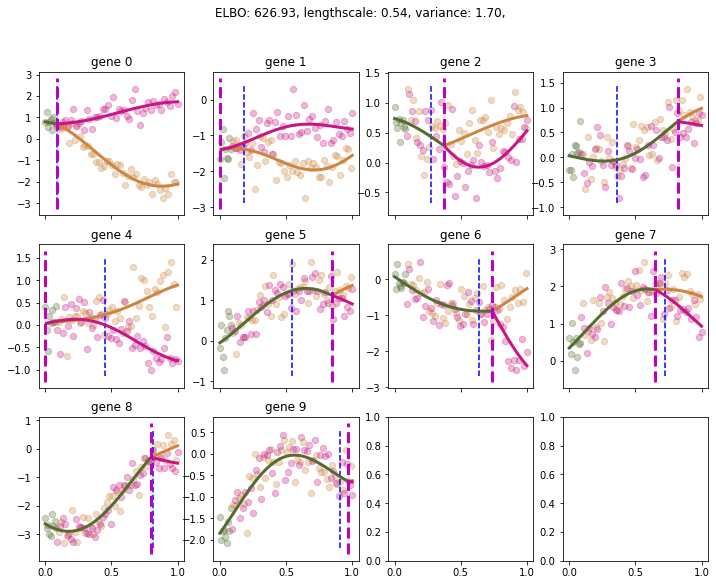

Slicing for gene 0
Uninformative until idx: 80


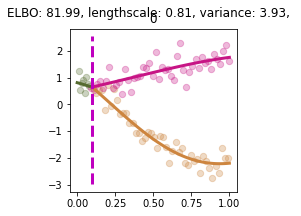

Slicing for gene 1
Uninformative until idx: 80


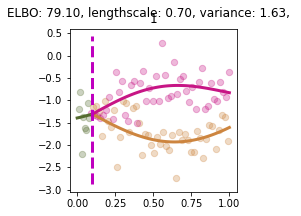

Slicing for gene 2
Uninformative until idx: 80


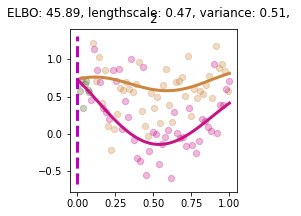

Slicing for gene 3
Uninformative until idx: 80


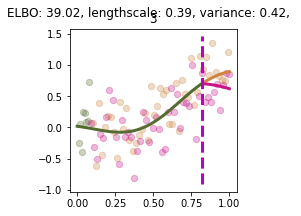

Slicing for gene 4
Uninformative until idx: 80


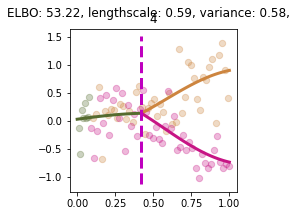

Slicing for gene 5
Uninformative until idx: 80


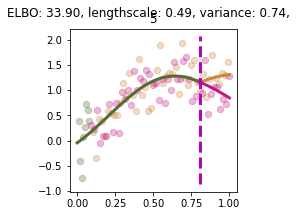

Slicing for gene 6
Uninformative until idx: 80


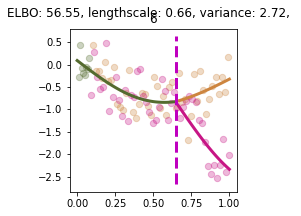

Slicing for gene 7
Uninformative until idx: 80


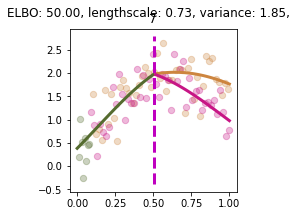

Slicing for gene 8
Uninformative until idx: 80


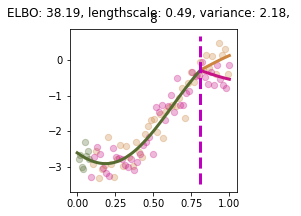

Slicing for gene 9
Uninformative until idx: 80


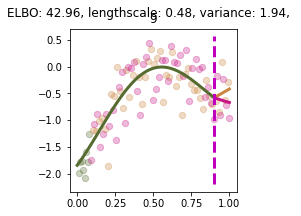

Processing sample 4
Uninformative until idx: 80


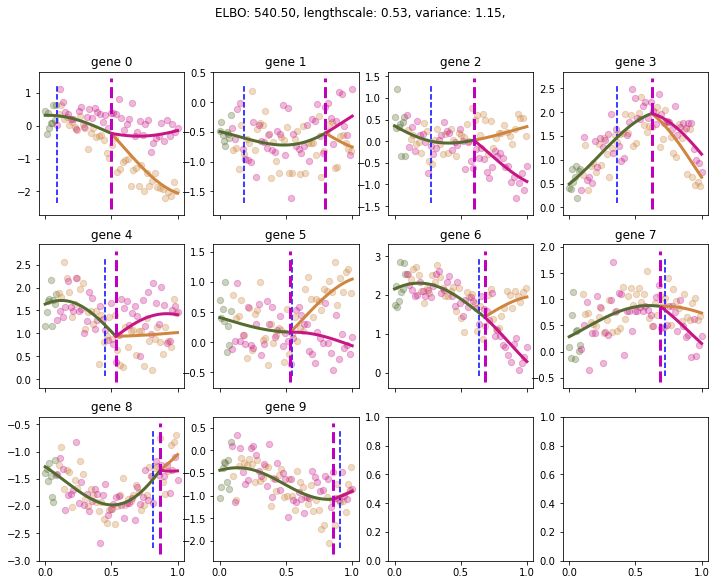

Slicing for gene 0
Uninformative until idx: 80


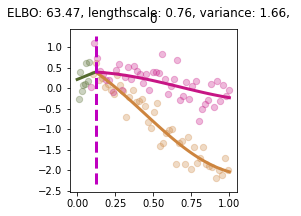

Slicing for gene 1
Uninformative until idx: 80


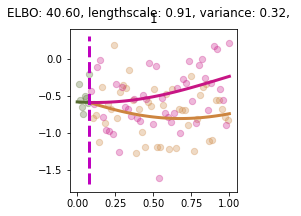

Slicing for gene 2
Uninformative until idx: 80


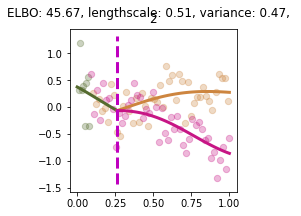

Slicing for gene 3
Uninformative until idx: 80


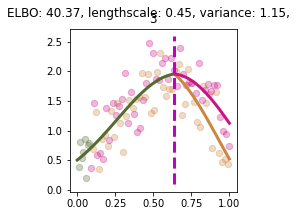

Slicing for gene 4
Uninformative until idx: 80


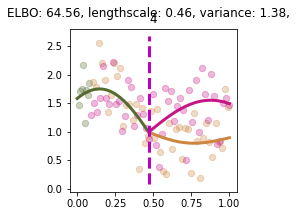

Slicing for gene 5
Uninformative until idx: 80


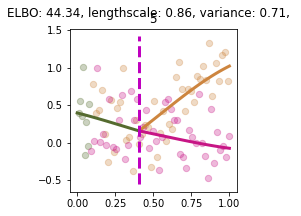

Slicing for gene 6
Uninformative until idx: 80


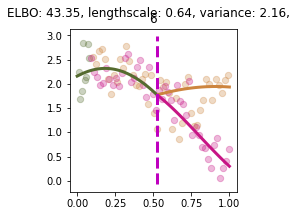

Slicing for gene 7
Uninformative until idx: 80


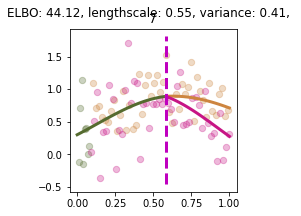

Slicing for gene 8
Uninformative until idx: 80


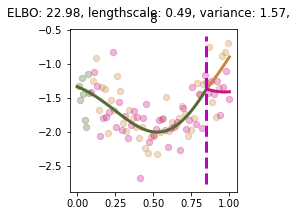

Slicing for gene 9
Uninformative until idx: 80


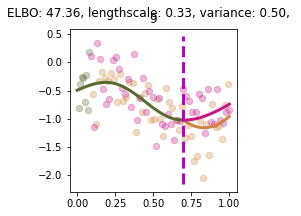

Processing sample 5
Uninformative until idx: 80


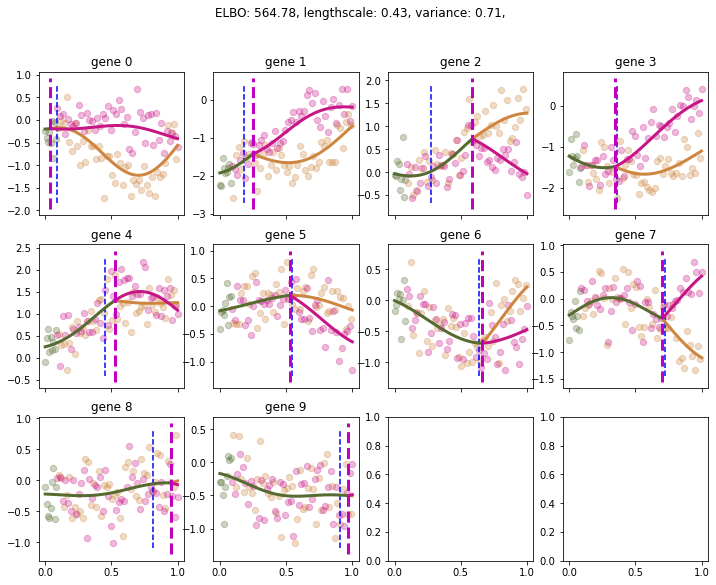

Slicing for gene 0
Uninformative until idx: 80


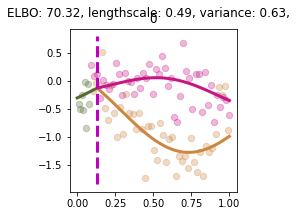

Slicing for gene 1
Uninformative until idx: 80


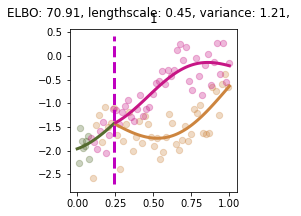

Slicing for gene 2
Uninformative until idx: 80


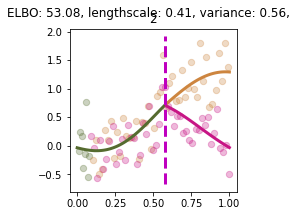

Slicing for gene 3
Uninformative until idx: 80


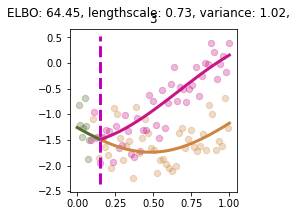

Slicing for gene 4
Uninformative until idx: 80


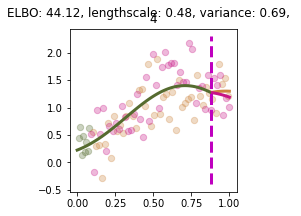

Slicing for gene 5
Uninformative until idx: 80


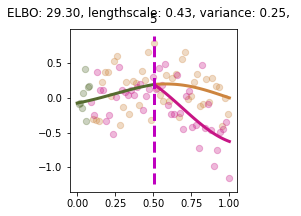

Slicing for gene 6
Uninformative until idx: 80


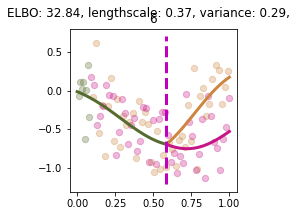

Slicing for gene 7
Uninformative until idx: 80


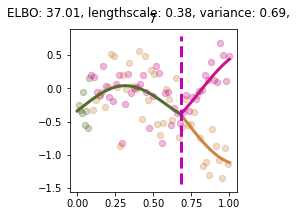

Slicing for gene 8
Uninformative until idx: 80


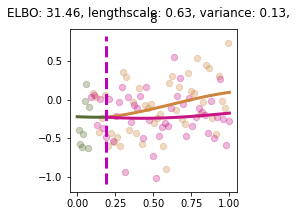

Slicing for gene 9
Uninformative until idx: 80


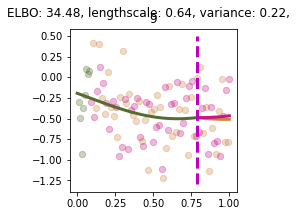

Processing sample 6
Uninformative until idx: 80


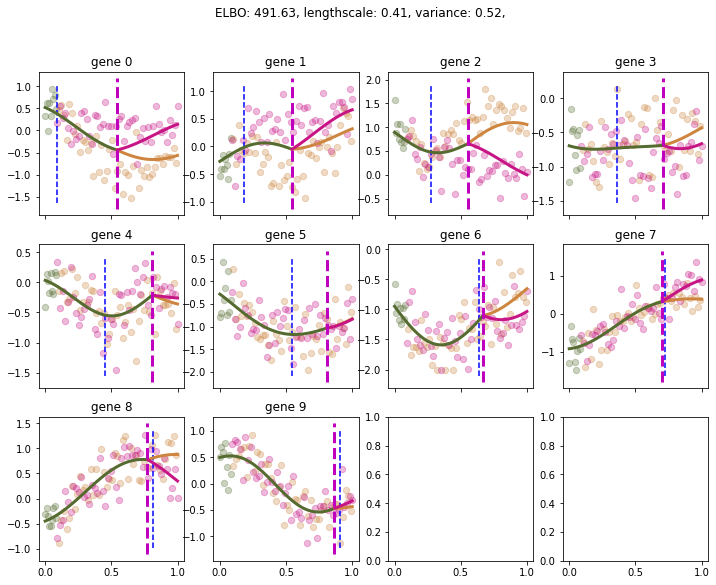

Slicing for gene 0
Uninformative until idx: 80


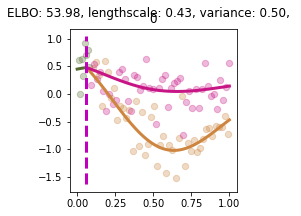

Slicing for gene 1
Uninformative until idx: 80


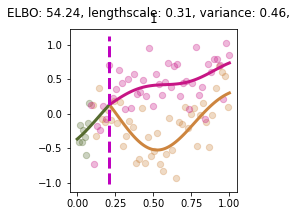

Slicing for gene 2
Uninformative until idx: 80


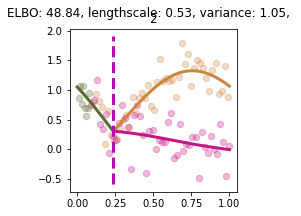

Slicing for gene 3
Uninformative until idx: 80


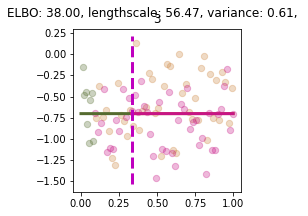

Slicing for gene 4
Uninformative until idx: 80


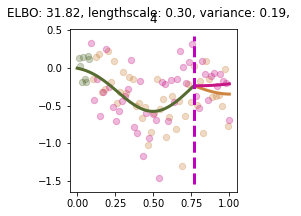

Slicing for gene 5
Uninformative until idx: 80


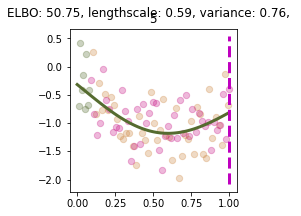

Slicing for gene 6
Uninformative until idx: 80


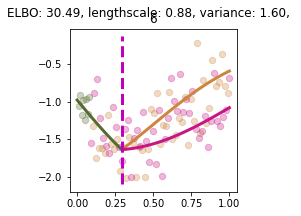

Slicing for gene 7
Uninformative until idx: 80


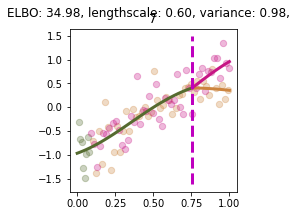

Slicing for gene 8
Uninformative until idx: 80


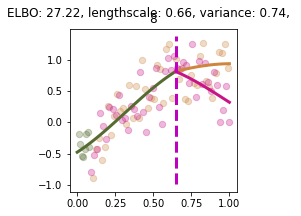

Slicing for gene 9
Uninformative until idx: 80


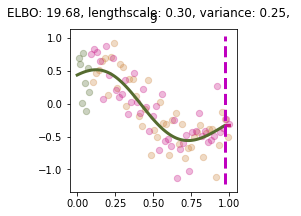

Processing sample 7
Uninformative until idx: 80


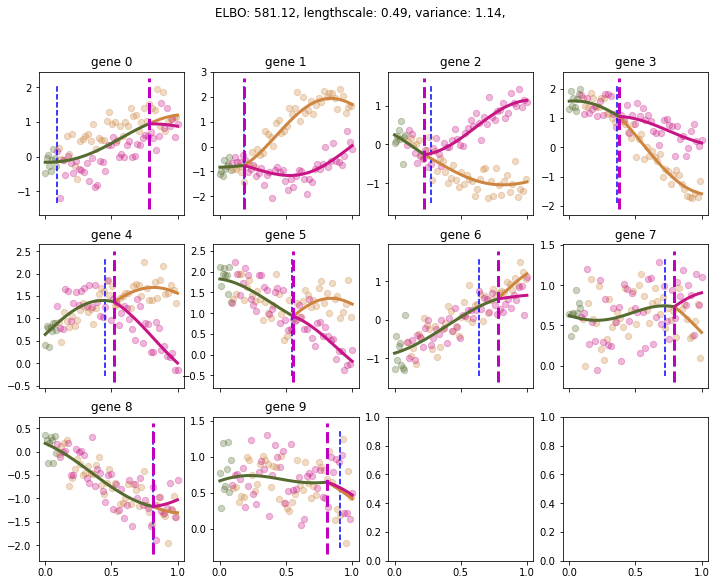

Slicing for gene 0
Uninformative until idx: 80


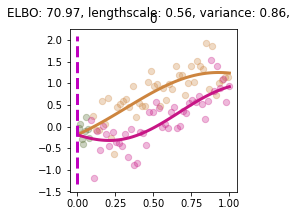

Slicing for gene 1
Uninformative until idx: 80


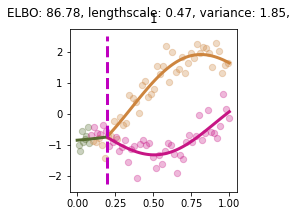

Slicing for gene 2
Uninformative until idx: 80


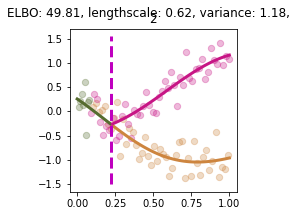

Slicing for gene 3
Uninformative until idx: 80


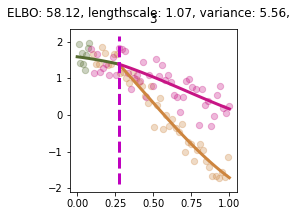

Slicing for gene 4
Uninformative until idx: 80


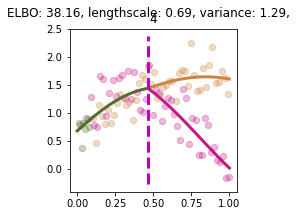

Slicing for gene 5
Uninformative until idx: 80


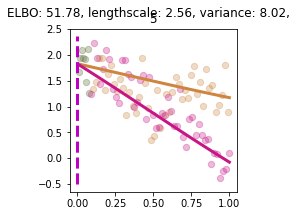

Slicing for gene 6
Uninformative until idx: 80


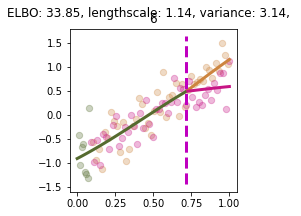

Slicing for gene 7
Uninformative until idx: 80


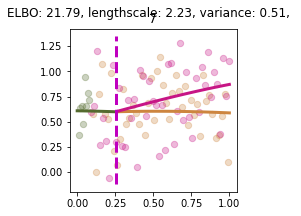

Slicing for gene 8
Uninformative until idx: 80


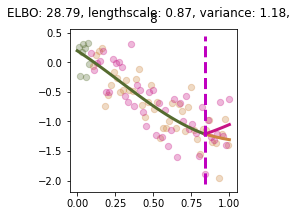

Slicing for gene 9
Uninformative until idx: 80


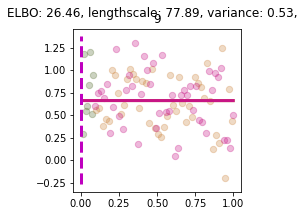

Processing sample 8
Uninformative until idx: 80


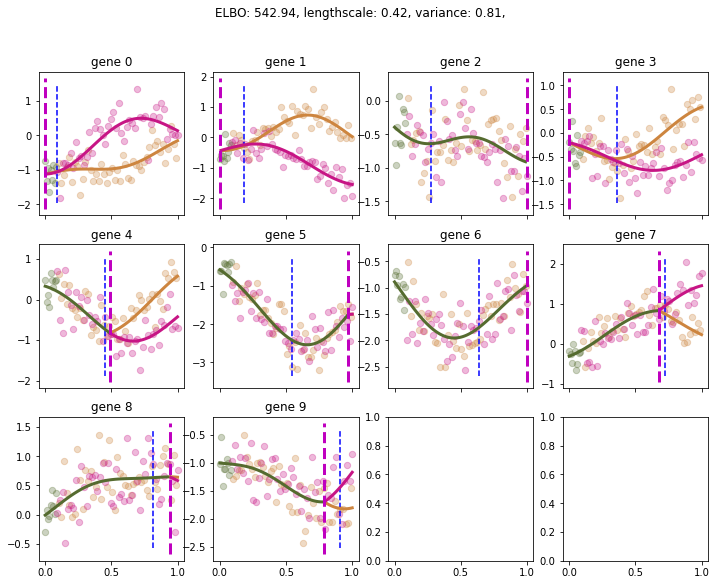

Slicing for gene 0
Uninformative until idx: 80


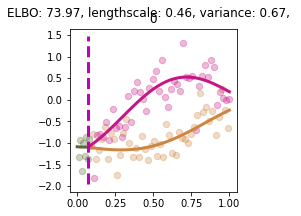

Slicing for gene 1
Uninformative until idx: 80


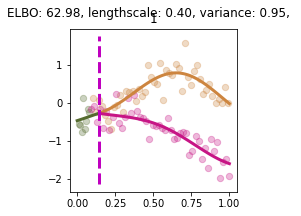

Slicing for gene 2
Uninformative until idx: 80


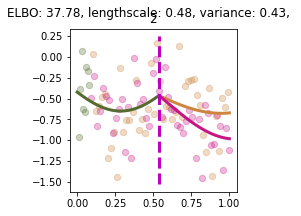

Slicing for gene 3
Uninformative until idx: 80


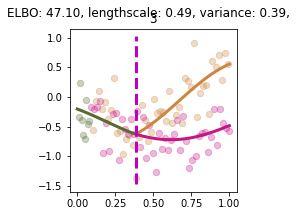

Slicing for gene 4
Uninformative until idx: 80


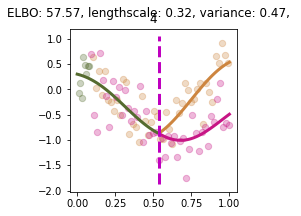

Slicing for gene 5
Uninformative until idx: 80


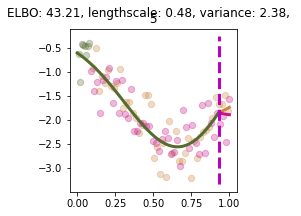

Slicing for gene 6
Uninformative until idx: 80


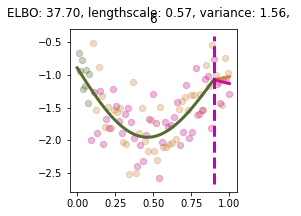

Slicing for gene 7
Uninformative until idx: 80


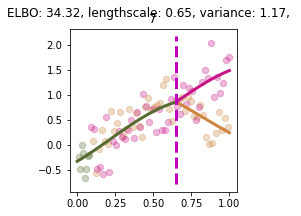

Slicing for gene 8
Uninformative until idx: 80


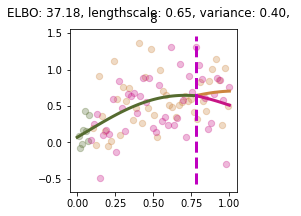

Slicing for gene 9
Uninformative until idx: 80


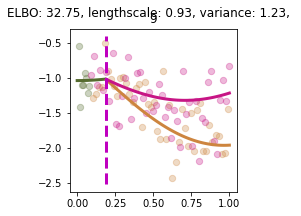

Processing sample 9
Uninformative until idx: 80


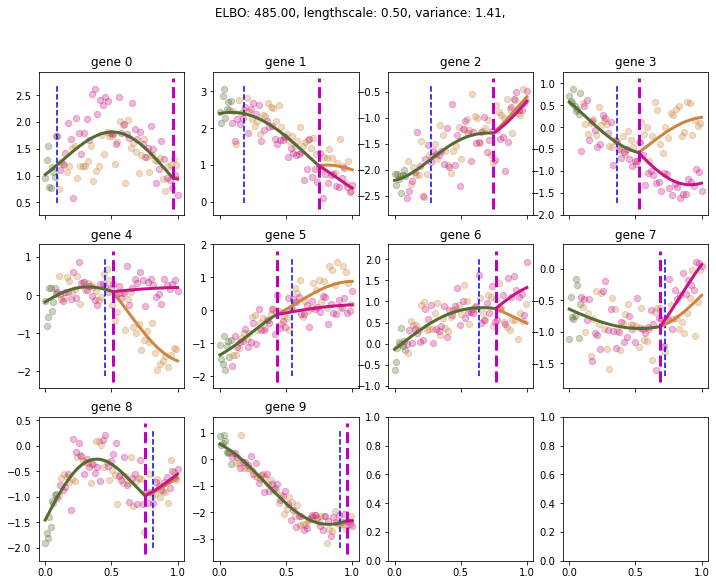

Slicing for gene 0
Uninformative until idx: 80


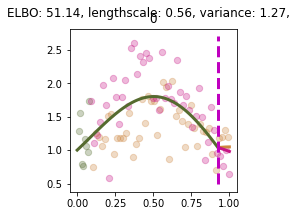

Slicing for gene 1
Uninformative until idx: 80


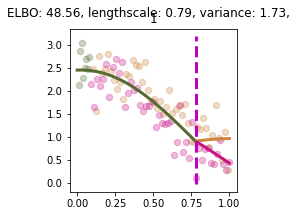

Slicing for gene 2
Uninformative until idx: 80


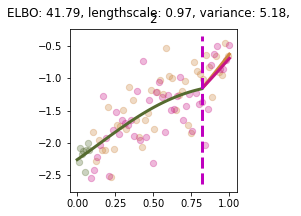

Slicing for gene 3
Uninformative until idx: 80


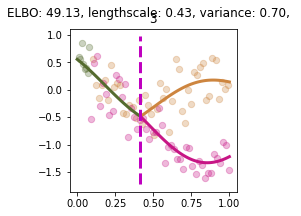

Slicing for gene 4
Uninformative until idx: 80


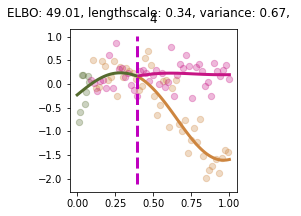

Slicing for gene 5
Uninformative until idx: 80


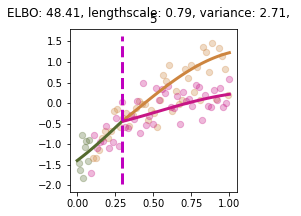

Slicing for gene 6
Uninformative until idx: 80


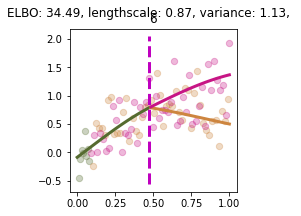

Slicing for gene 7
Uninformative until idx: 80


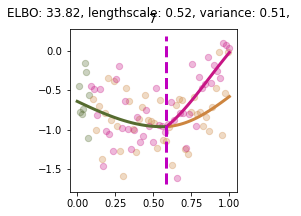

Slicing for gene 8
Uninformative until idx: 80


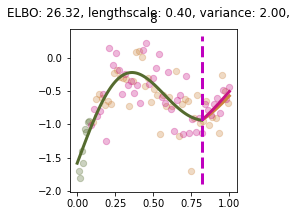

Slicing for gene 9
Uninformative until idx: 80


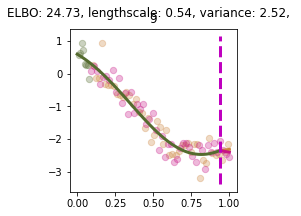

Processing sample 10
Uninformative until idx: 80


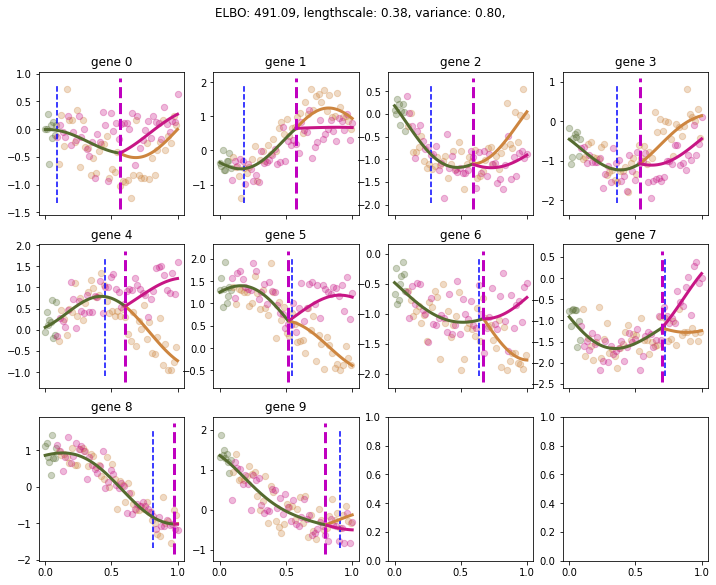

Slicing for gene 0
Uninformative until idx: 80


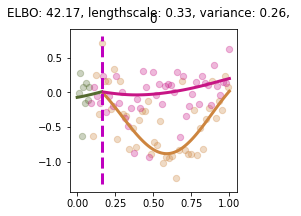

Slicing for gene 1
Uninformative until idx: 80


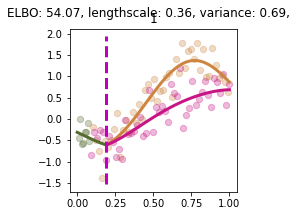

Slicing for gene 2
Uninformative until idx: 80


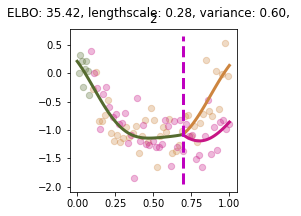

Slicing for gene 3
Uninformative until idx: 80


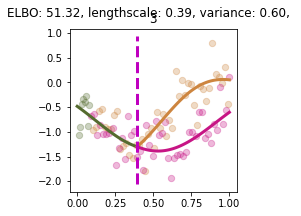

Slicing for gene 4
Uninformative until idx: 80


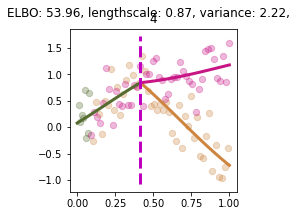

Slicing for gene 5
Uninformative until idx: 80


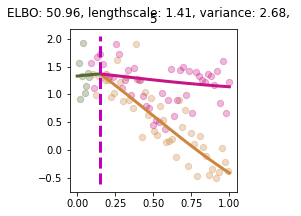

Slicing for gene 6
Uninformative until idx: 80


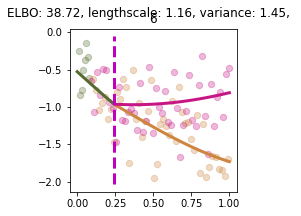

Slicing for gene 7
Uninformative until idx: 80


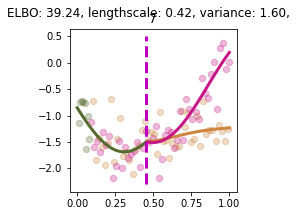

Slicing for gene 8
Uninformative until idx: 80


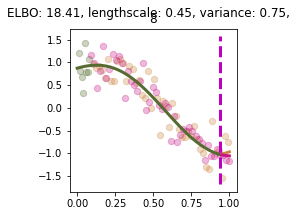

Slicing for gene 9
Uninformative until idx: 80


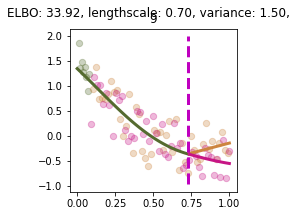

Processing sample 11
Uninformative until idx: 80


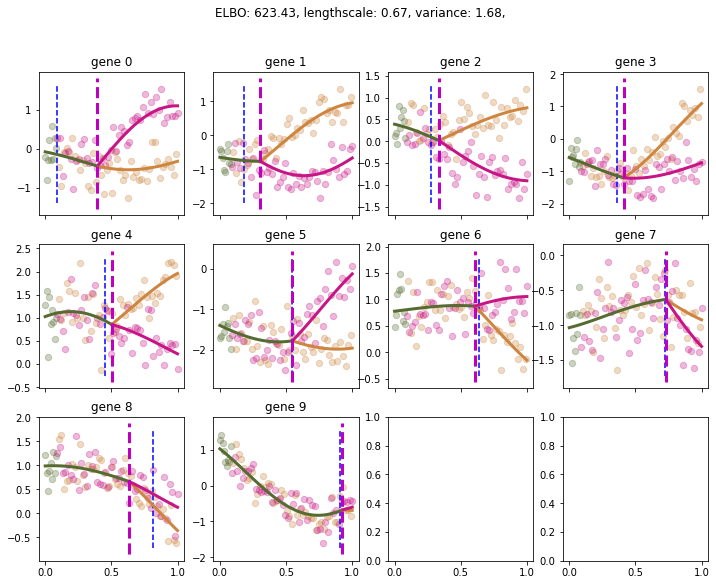

Slicing for gene 0
Uninformative until idx: 80


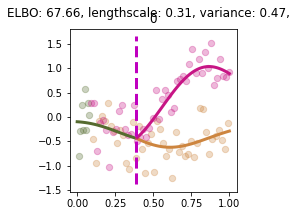

Slicing for gene 1
Uninformative until idx: 80


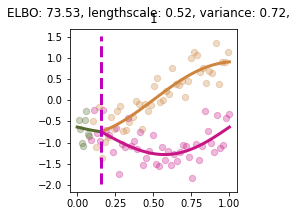

Slicing for gene 2
Uninformative until idx: 80


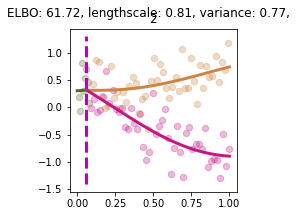

Slicing for gene 3
Uninformative until idx: 80


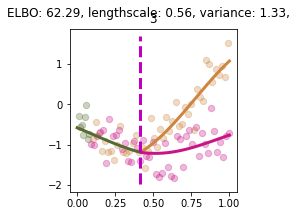

Slicing for gene 4
Uninformative until idx: 80


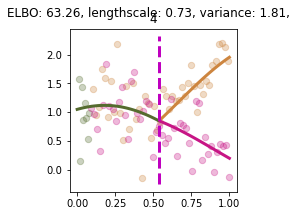

Slicing for gene 5
Uninformative until idx: 80


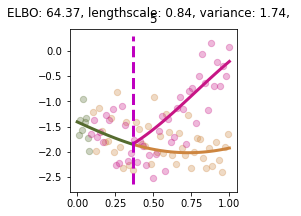

Slicing for gene 6
Uninformative until idx: 80


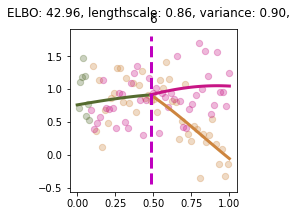

Slicing for gene 7
Uninformative until idx: 80


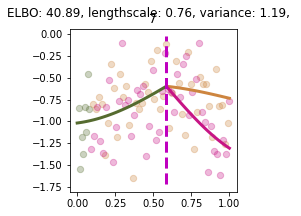

Slicing for gene 8
Uninformative until idx: 80


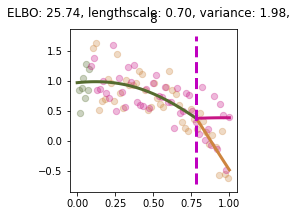

Slicing for gene 9
Uninformative until idx: 80


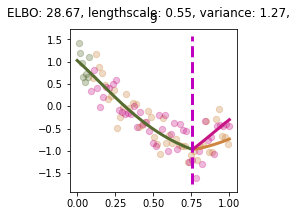

Processing sample 12
Uninformative until idx: 80


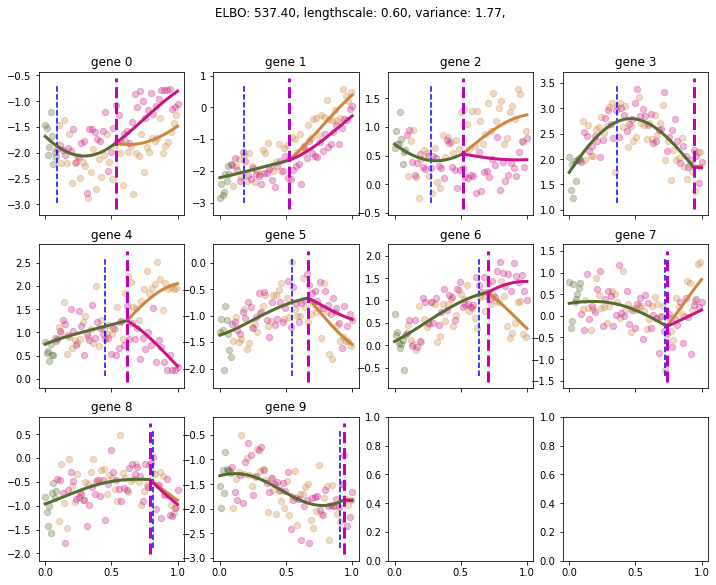

Slicing for gene 0
Uninformative until idx: 80


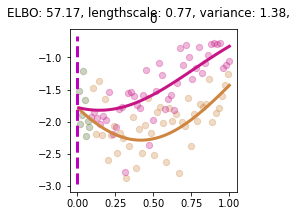

Slicing for gene 1
Uninformative until idx: 80


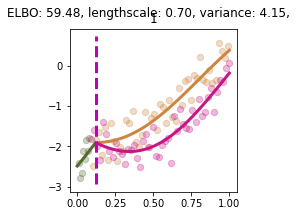

Slicing for gene 2
Uninformative until idx: 80


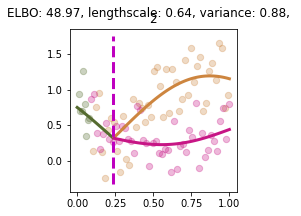

Slicing for gene 3
Uninformative until idx: 80


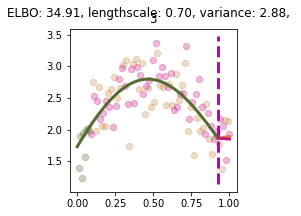

Slicing for gene 4
Uninformative until idx: 80


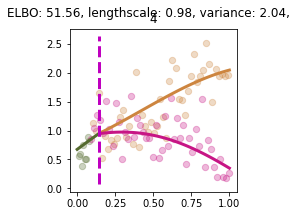

Slicing for gene 5
Uninformative until idx: 80


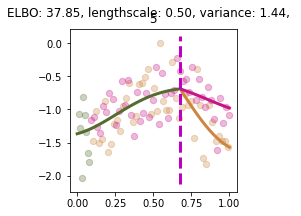

Slicing for gene 6
Uninformative until idx: 80


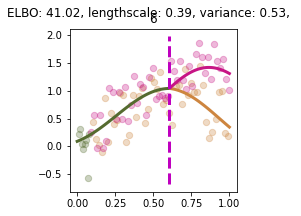

Slicing for gene 7
Uninformative until idx: 80


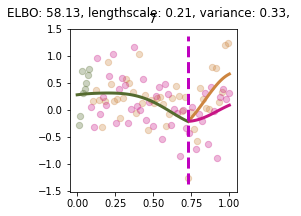

Slicing for gene 8
Uninformative until idx: 80


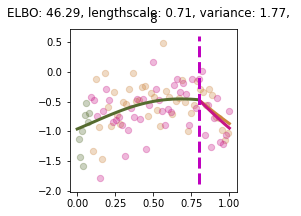

Slicing for gene 9
Uninformative until idx: 80
Error in training:  Input is not invertible.
	 [[node f0f2_1/invKbb (defined at /Users/elvijssarkans/dev/MMBGP/MMBGP/assigngp.py:154) ]] [Op:__inference__tf_eval_75036203]

Errors may have originated from an input operation.
Input Source operations connected to node f0f2_1/invKbb:
 f0f2_1/add_2 (defined at /Users/elvijssarkans/dev/MMBGP/MMBGP/assigngp.py:153)

Function call stack:
_tf_eval



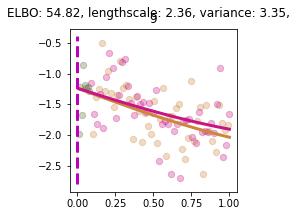

Processing sample 13
Uninformative until idx: 80


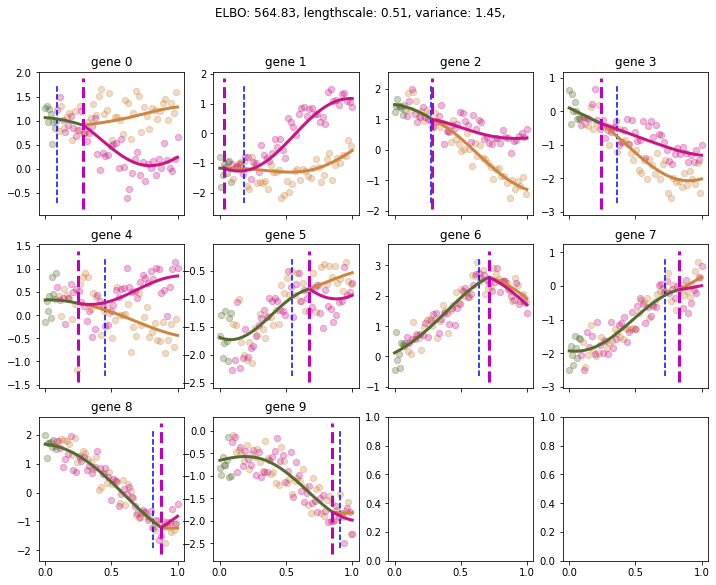

Slicing for gene 0
Uninformative until idx: 80


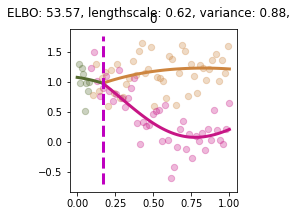

Slicing for gene 1
Uninformative until idx: 80


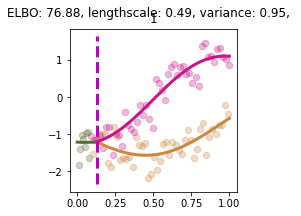

Slicing for gene 2
Uninformative until idx: 80


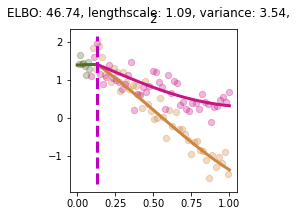

Slicing for gene 3
Uninformative until idx: 80


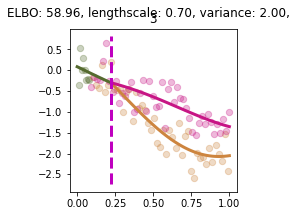

Slicing for gene 4
Uninformative until idx: 80


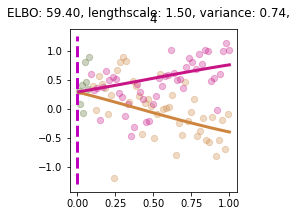

Slicing for gene 5
Uninformative until idx: 80


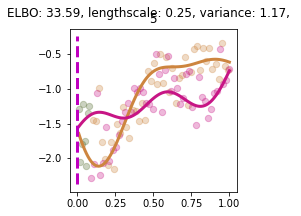

Slicing for gene 6
Uninformative until idx: 80


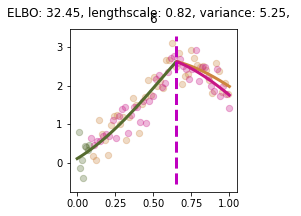

Slicing for gene 7
Uninformative until idx: 80


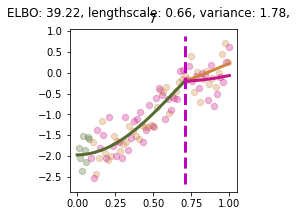

Slicing for gene 8
Uninformative until idx: 80


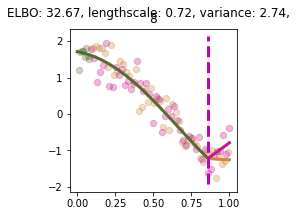

Slicing for gene 9
Uninformative until idx: 80


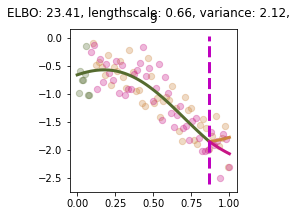

Processing sample 14
Uninformative until idx: 80


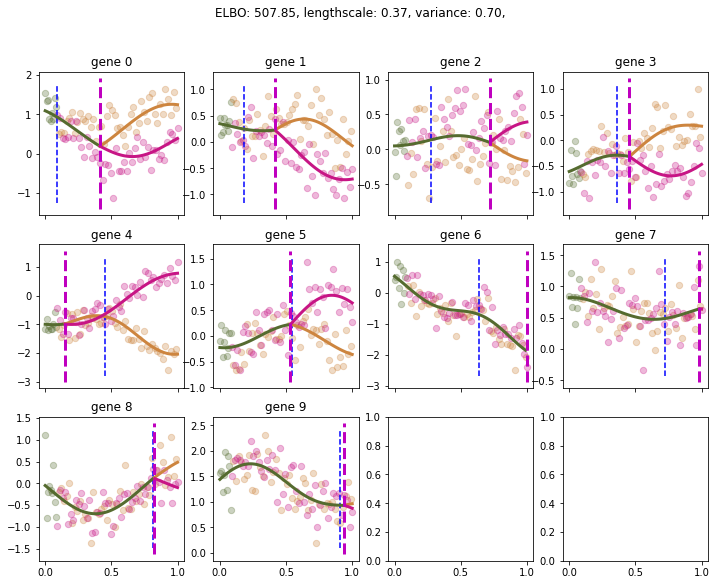

Slicing for gene 0
Uninformative until idx: 80


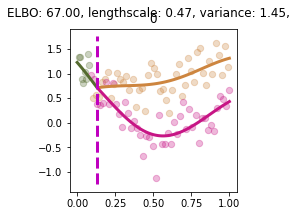

Slicing for gene 1
Uninformative until idx: 80


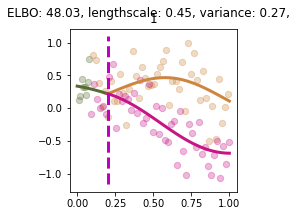

Slicing for gene 2
Uninformative until idx: 80


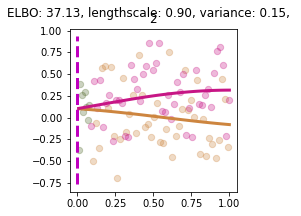

Slicing for gene 3
Uninformative until idx: 80


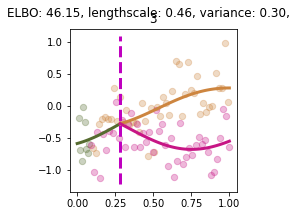

Slicing for gene 4
Uninformative until idx: 80


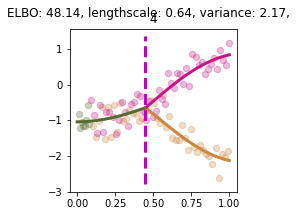

Slicing for gene 5
Uninformative until idx: 80


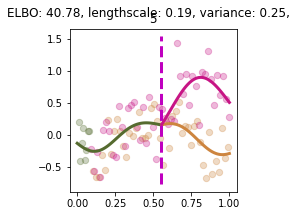

Slicing for gene 6
Uninformative until idx: 80


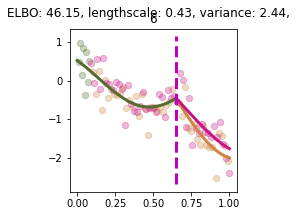

Slicing for gene 7
Uninformative until idx: 80


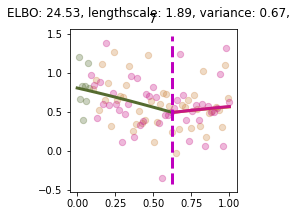

Slicing for gene 8
Uninformative until idx: 80


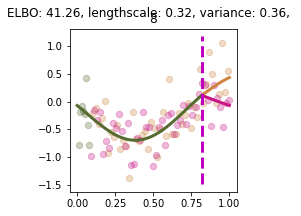

Slicing for gene 9
Uninformative until idx: 80


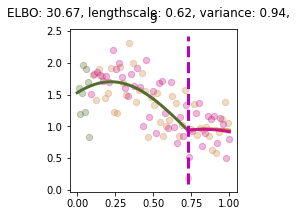

Processing sample 15
Uninformative until idx: 80


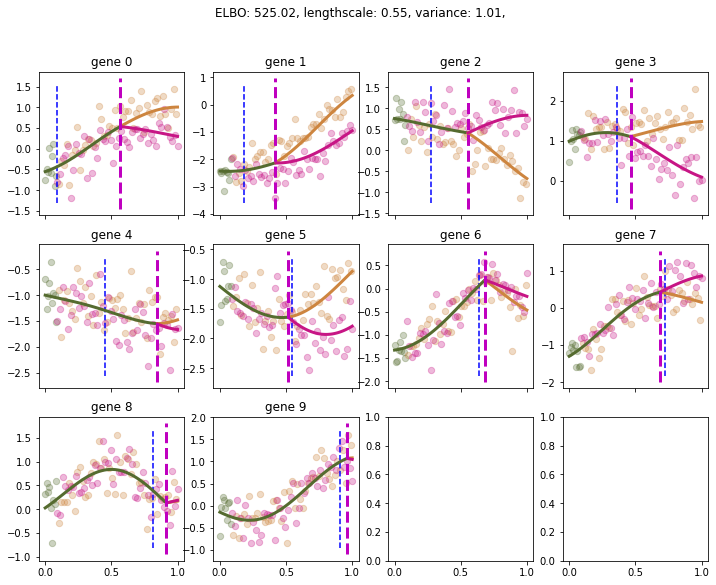

Slicing for gene 0
Uninformative until idx: 80


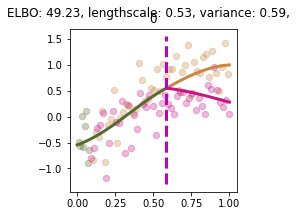

Slicing for gene 1
Uninformative until idx: 80


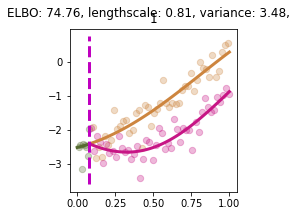

Slicing for gene 2
Uninformative until idx: 80


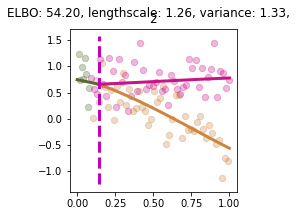

Slicing for gene 3
Uninformative until idx: 80


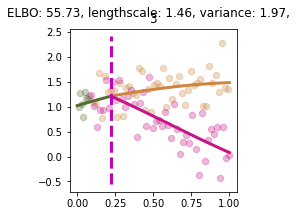

Slicing for gene 4
Uninformative until idx: 80


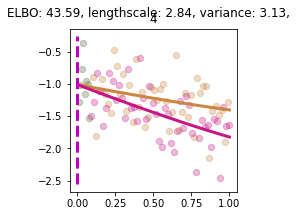

Slicing for gene 5
Uninformative until idx: 80


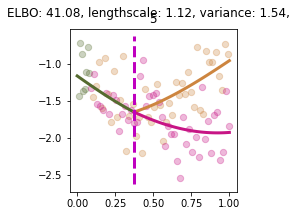

Slicing for gene 6
Uninformative until idx: 80


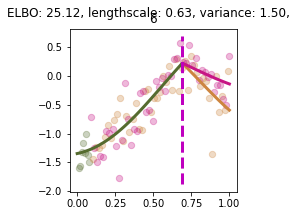

Slicing for gene 7
Uninformative until idx: 80


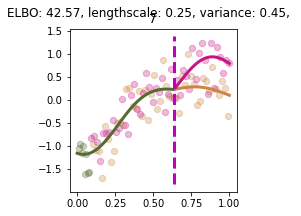

Slicing for gene 8
Uninformative until idx: 80


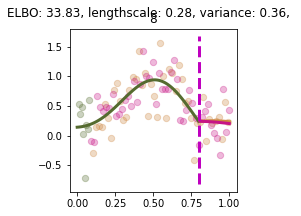

Slicing for gene 9
Uninformative until idx: 80


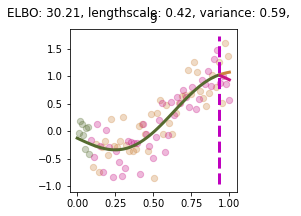

Processing sample 16
Uninformative until idx: 80


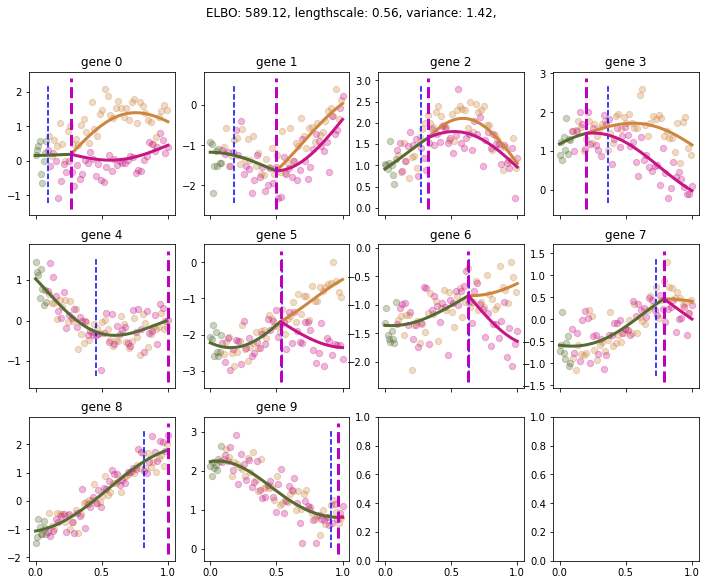

Slicing for gene 0
Uninformative until idx: 80


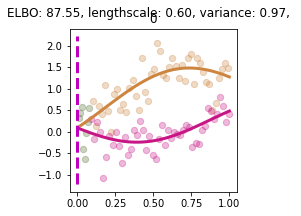

Slicing for gene 1
Uninformative until idx: 80


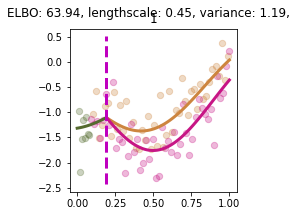

Slicing for gene 2
Uninformative until idx: 80
Error in training:  Input is not invertible.
	 [[node f2f0_1/invKbb (defined at /Users/elvijssarkans/dev/MMBGP/MMBGP/assigngp.py:154) ]] [Op:__inference__tf_eval_81704628]

Errors may have originated from an input operation.
Input Source operations connected to node f2f0_1/invKbb:
 f2f0_1/add_2 (defined at /Users/elvijssarkans/dev/MMBGP/MMBGP/assigngp.py:153)

Function call stack:
_tf_eval



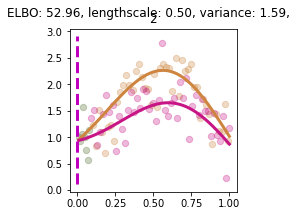

Slicing for gene 3
Uninformative until idx: 80


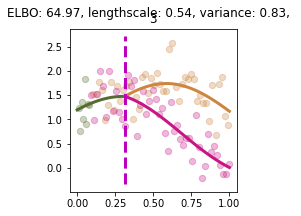

Slicing for gene 4
Uninformative until idx: 80


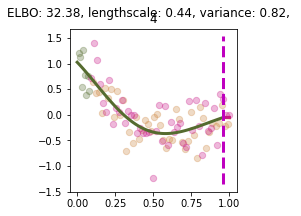

Slicing for gene 5
Uninformative until idx: 80


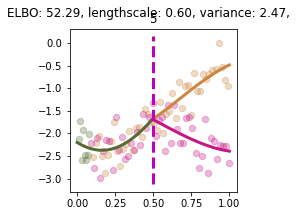

Slicing for gene 6
Uninformative until idx: 80


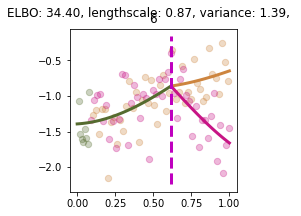

Slicing for gene 7
Uninformative until idx: 80


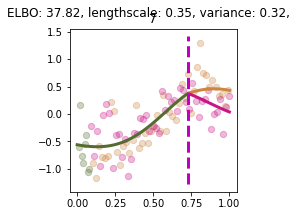

Slicing for gene 8
Uninformative until idx: 80


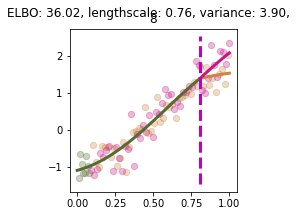

Slicing for gene 9
Uninformative until idx: 80


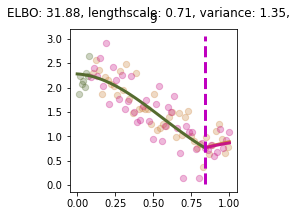

Processing sample 17
Uninformative until idx: 80


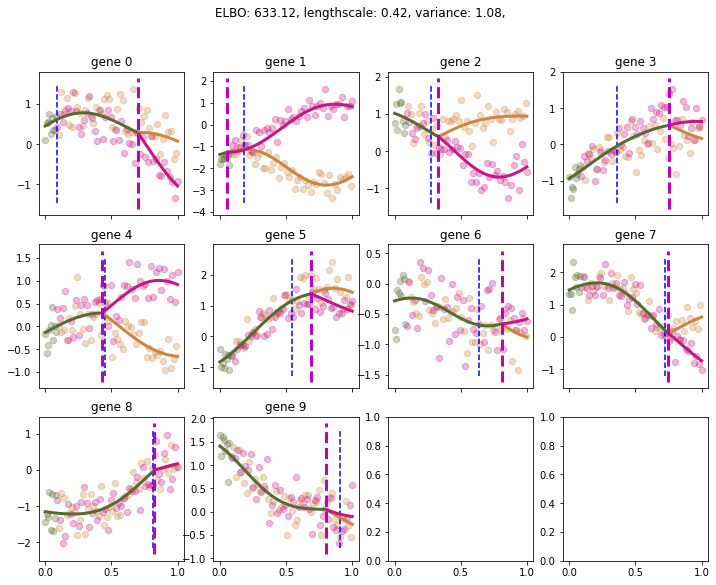

Slicing for gene 0
Uninformative until idx: 80


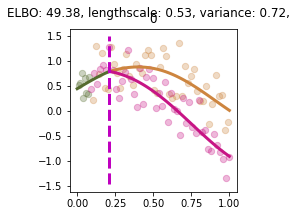

Slicing for gene 1
Uninformative until idx: 80


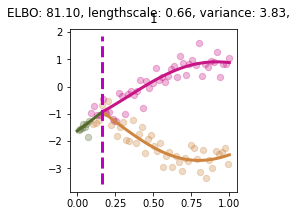

Slicing for gene 2
Uninformative until idx: 80


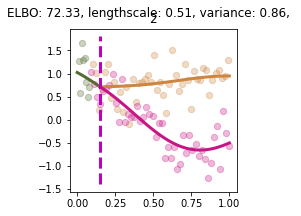

Slicing for gene 3
Uninformative until idx: 80


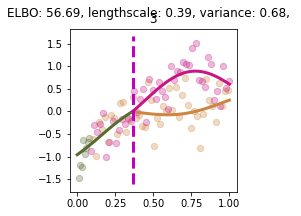

Slicing for gene 4
Uninformative until idx: 80


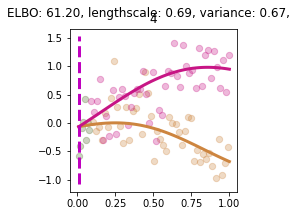

Slicing for gene 5
Uninformative until idx: 80


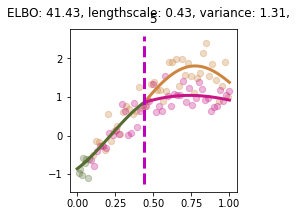

Slicing for gene 6
Uninformative until idx: 80


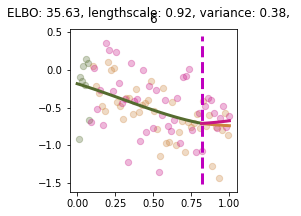

Slicing for gene 7
Uninformative until idx: 80


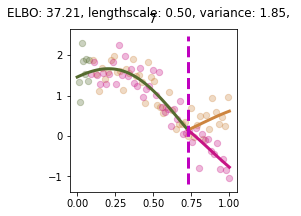

Slicing for gene 8
Uninformative until idx: 80


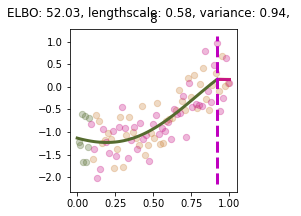

Slicing for gene 9
Uninformative until idx: 80


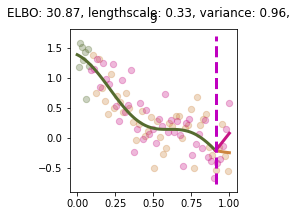

Processing sample 18
Uninformative until idx: 80


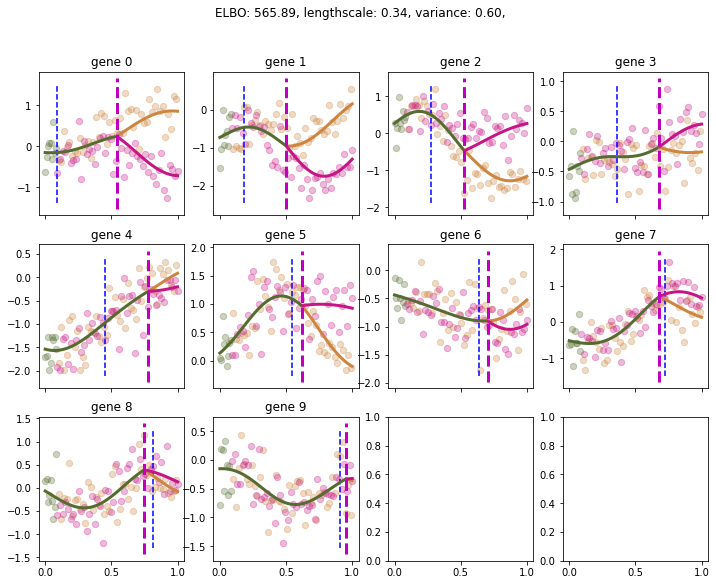

Slicing for gene 0
Uninformative until idx: 80


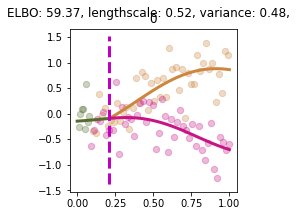

Slicing for gene 1
Uninformative until idx: 80


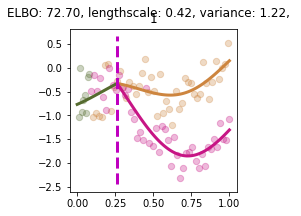

Slicing for gene 2
Uninformative until idx: 80


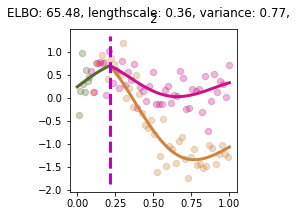

Slicing for gene 3
Uninformative until idx: 80


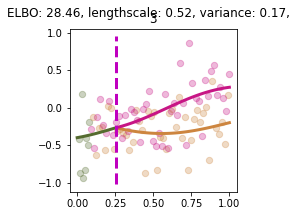

Slicing for gene 4
Uninformative until idx: 80


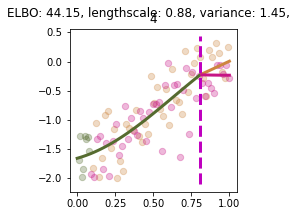

Slicing for gene 5
Uninformative until idx: 80


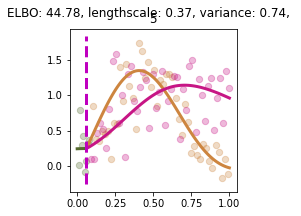

Slicing for gene 6
Uninformative until idx: 80


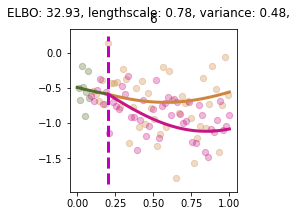

Slicing for gene 7
Uninformative until idx: 80


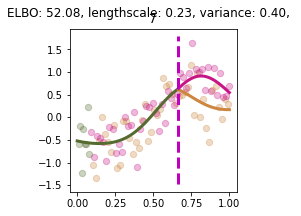

Slicing for gene 8
Uninformative until idx: 80


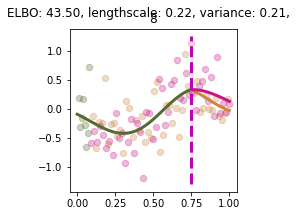

Slicing for gene 9
Uninformative until idx: 80


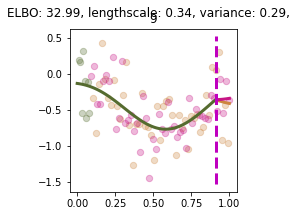

Processing sample 19
Uninformative until idx: 80


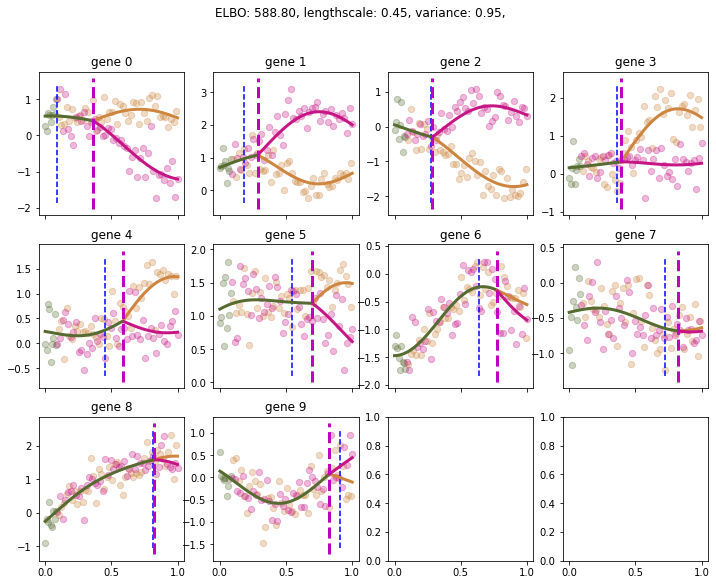

Slicing for gene 0
Uninformative until idx: 80


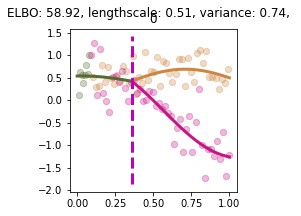

Slicing for gene 1
Uninformative until idx: 80


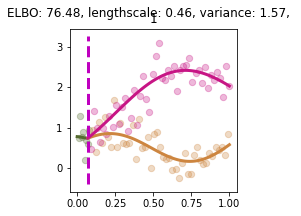

Slicing for gene 2
Uninformative until idx: 80


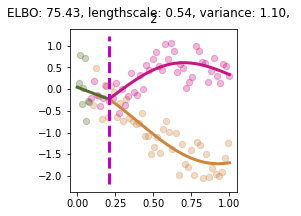

Slicing for gene 3
Uninformative until idx: 80


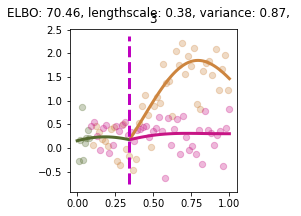

Slicing for gene 4
Uninformative until idx: 80


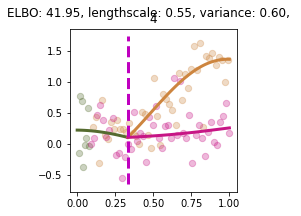

Slicing for gene 5
Uninformative until idx: 80


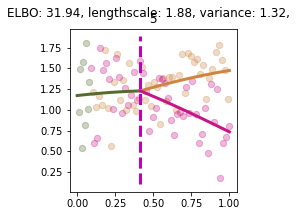

Slicing for gene 6
Uninformative until idx: 80


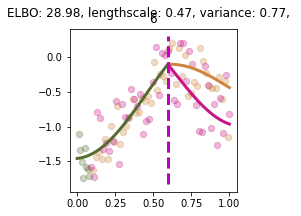

Slicing for gene 7
Uninformative until idx: 80


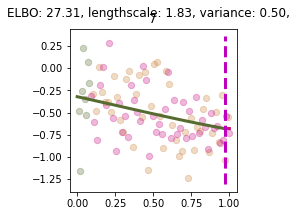

Slicing for gene 8
Uninformative until idx: 80


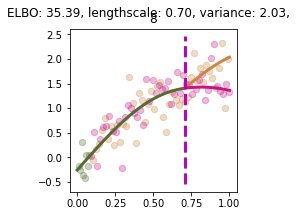

Slicing for gene 9
Uninformative until idx: 80


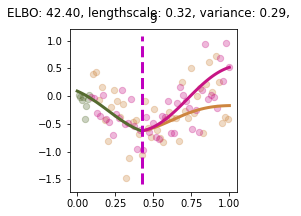

In [19]:
from MMBGP.training_helpers import fixed_bps


NOISE = 0.1
LENGTHSCALE = 0.5

NUM_SAMPLES = 20
TRUE_BPS = [i/11 for i in range(1, 11, 1)]
NUM_CELLS = 100


HIGH_PRIOR_CONFIDENCE = 0.8

dummy_model = get_assigngp_with_target_bps(
    TRUE_BPS, 
    lengthscale=LENGTHSCALE, 
    noise_variance=NOISE,
)
synthetic_noisy_data = get_synthetic_noisy_branched_data(
    dummy_model, 
    num_samples=NUM_SAMPLES, 
    x_pts=NUM_CELLS,
)


LOW_PRIOR_CONFIDENCE = 0.8
UNINFORMATIVE_UNTIL = 0.8

funky_prior_results: List[Result] = []

for i, data in enumerate(synthetic_noisy_data):
    print(f"Processing sample {i}")
    
    #
    # MMBGP
    #
    mmbgp = construct_assigngp_model(
        gene_expression=data,
        phi_constructor=FunkyPrior(
            data,
            informative_prior_confidence=HIGH_PRIOR_CONFIDENCE, 
            uninformative_until=UNINFORMATIVE_UNTIL,
        ),
        initial_branching_points=[0.5]*data.num_genes,  # Don't start at the true locations
    )
    
    optimiser = ElvijsAmazingOptimiser()
    try:
        trained_mmbgp = optimiser.train(mmbgp)
    except Exception as ex:
        print(f"Error in training: {ex}")
        trained_mmbgp = mmbgp
    
    plot_model_snapshot(trained_mmbgp, genes=data, alpha=0.3)
    plt.show()
    
    #
    # BGPs
    #
    bgps = []

    for i in range(data.num_genes):
        print(f"Slicing for gene {i}")
    
        sliced_data = GeneExpressionData(
            t=data.t,
            Y=data.Y[:, i].reshape(-1, 1),
            state=data.state,
            gene_labels=[f"{i}"]
        )
   
        bgp = construct_assigngp_model(
            gene_expression=sliced_data,
            phi_constructor=FunkyPrior(
                sliced_data,
                informative_prior_confidence=HIGH_PRIOR_CONFIDENCE, 
                uninformative_until=UNINFORMATIVE_UNTIL,
            ),
            initial_branching_points=[0.5],  # Do not initialise to true locations
        )
    
        optimiser = ElvijsAmazingOptimiser()
        try:
            trained_bgp = optimiser.train(bgp)
        except Exception as ex:
            print(f"Error in training: {ex}")
            trained_bgp = bgp
            
        plot_model_snapshot(trained_bgp, genes=sliced_data, alpha=0.3)
        plt.show()
    
        bgps.append(trained_bgp)
    
    result = Result(
        data=data,
        true_bps=np.array(TRUE_BPS),
        mmbgp=trained_mmbgp,
        bgps=bgps,
    )
    funky_prior_results.append(result)

In [20]:
funky_prior_df = convert_results_to_df(funky_prior_results, inconsistency_threshold=0.6)
funky_prior_df.head(30)

sample_id  mmbgp_bp_rmse  bgp_bp_rmse  inconsistent_branches  \
0           0       0.303720     0.191687                     22   
1           1       0.143255     0.130244                     32   
2           2       0.167672     0.271013                     62   
3           3       0.238427     0.201825                     40   
4           4       0.270981     0.136299                     36   
5           5       0.116315     0.271310                     32   
6           6       0.270674     0.214614                     39   
7           7       0.228661     0.370855                     45   
8           8       0.323401     0.287048                     31   
9           9       0.370837     0.382874                     34   
10         10       0.238230     0.248421                     46   
11         11       0.123213     0.156620                     37   
12         12       0.273524     0.356581                     35   
13         13       0.126903     0.235963                     47   
14         14       0.256653     0.112457                     25   
15         15       0.231987     0.232485                     35   
16         16       0.223001     0.186651                     34   
17         17       0.246161     0.167676                     38   
18         18       0.243175     0.243951                     46   
19         19       0.125938     0.206969                     36   

    inconsistent_all  mean_mmbgp_correct_labels  mean_bgp_correct_labels  
0                 60                       77.7                     82.5  
1                 53                       87.8                     85.0  
2                 72                       85.6                     74.8  
3                 70                       81.9                     82.0  
4                 58                       81.3                     80.1  
5                 57                       90.8                     76.6  
6                 58                       78.2                     77.7  
7                 59                       88.4                     73.5  
8                 60                       73.5                     75.6  
9                 74                       74.0                     69.2  
10                61                       81.1                     73.9  
11                62                       91.6                     82.1  
12                50                       79.7                     72.2  
13                71                       87.3                     78.3  
14                50                       79.3                     86.2  
15                61                       82.3                     78.2  
16                65                       84.5                     83.4  
17                49                       83.2                     83.6  
18                66                       80.6                     75.6  
19                60                       89.9                     78.8

In [21]:
funky_prior_df.describe()

sample_id  mmbgp_bp_rmse  bgp_bp_rmse  inconsistent_branches  \
count   20.00000      20.000000    20.000000              20.000000   
mean     9.50000       0.226136     0.230277              37.600000   
std      5.91608       0.071619     0.077179               8.708133   
min      0.00000       0.116315     0.112457              22.000000   
25%      4.75000       0.161568     0.181907              33.500000   
50%      9.50000       0.238328     0.223549              36.000000   
75%     14.25000       0.270751     0.271087              41.250000   
max     19.00000       0.370837     0.382874              62.000000   

       inconsistent_all  mean_mmbgp_correct_labels  mean_bgp_correct_labels  
count         20.000000                   20.00000                20.000000  
mean          60.800000                   82.93500                78.465000  
std            7.266361                    5.24648                 4.603348  
min           49.000000                   73.50000                69.200000  
25%           57.750000                   79.60000                75.400000  
50%           60.000000                   82.10000                78.250000  
75%           65.250000                   87.42500                82.200000  
max           74.000000                   91.60000                86.200000

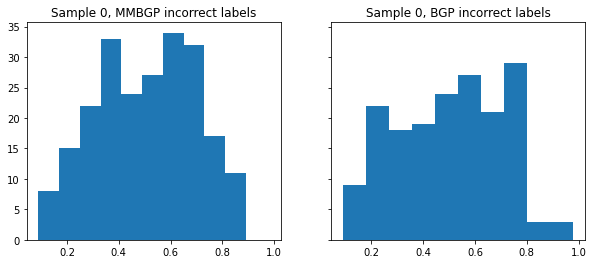

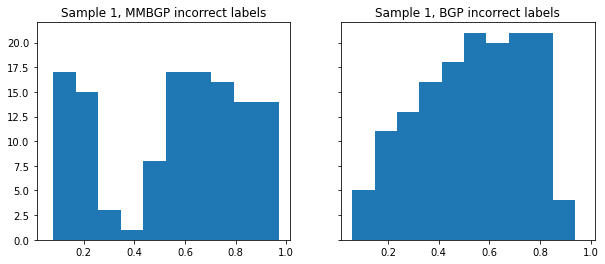

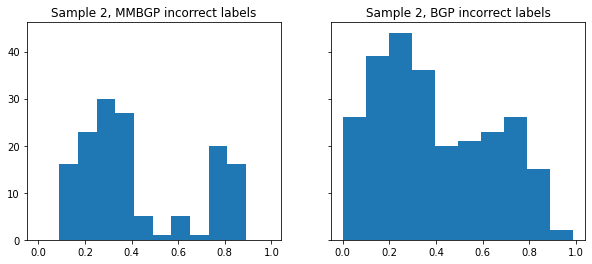

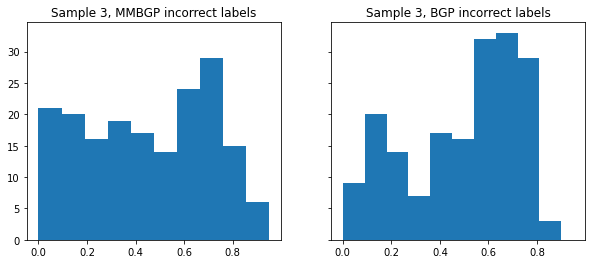

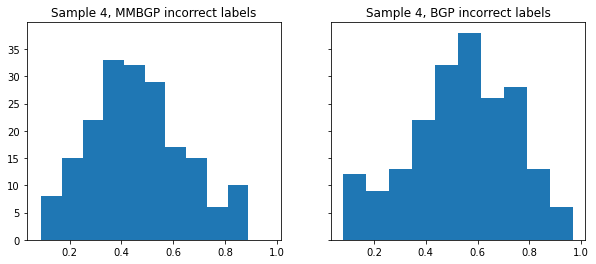

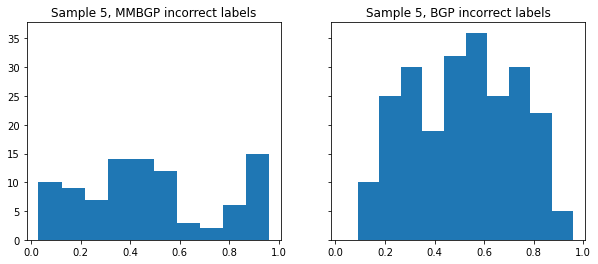

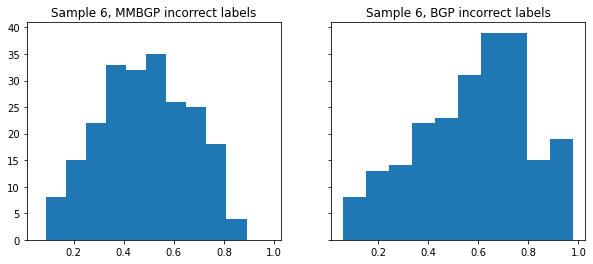

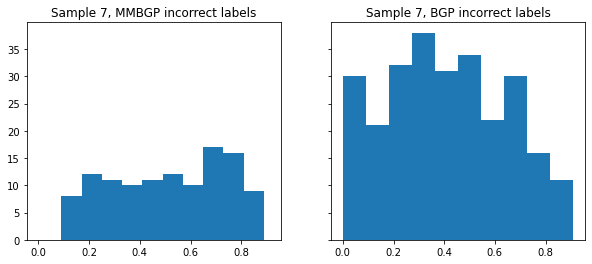

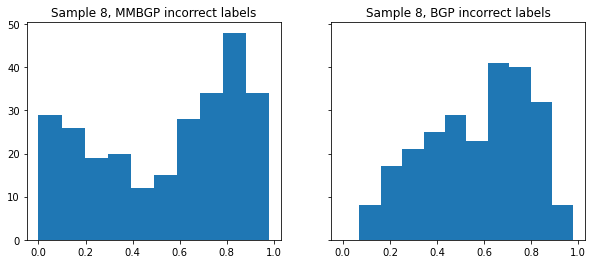

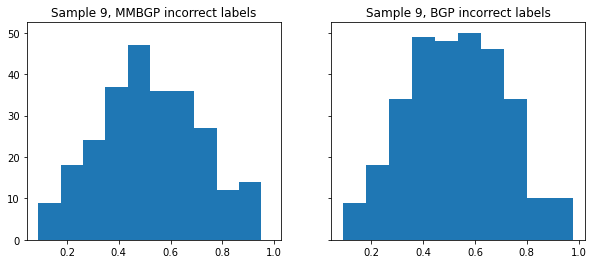

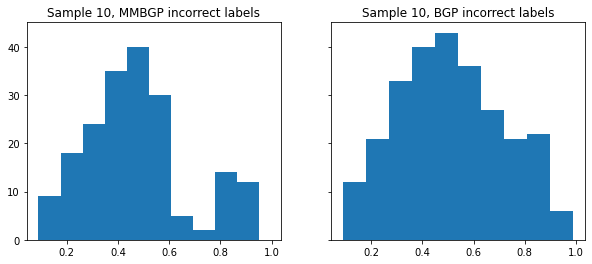

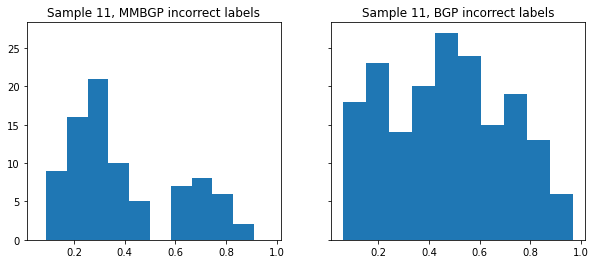

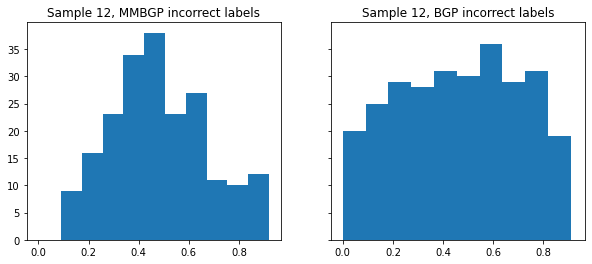

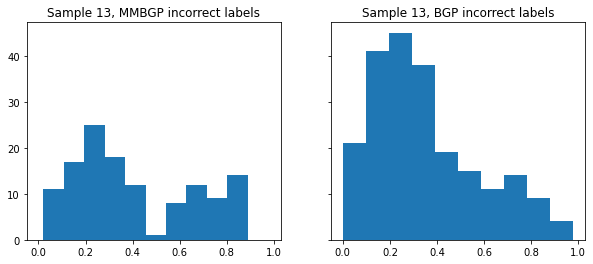

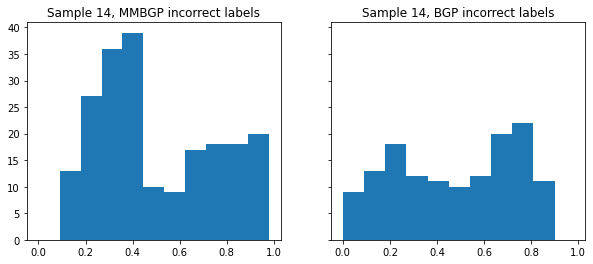

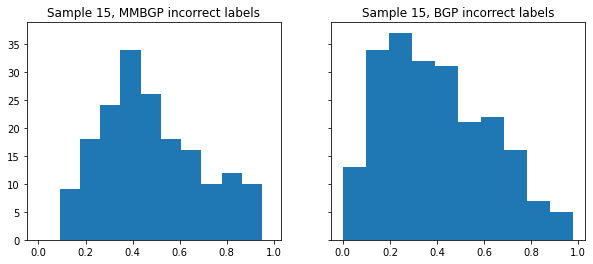

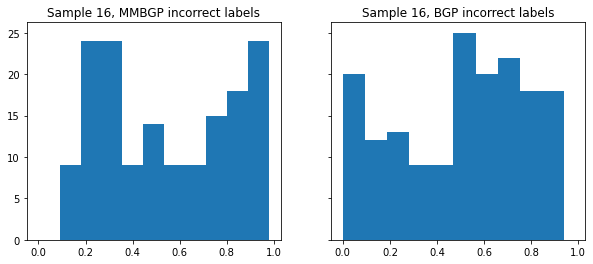

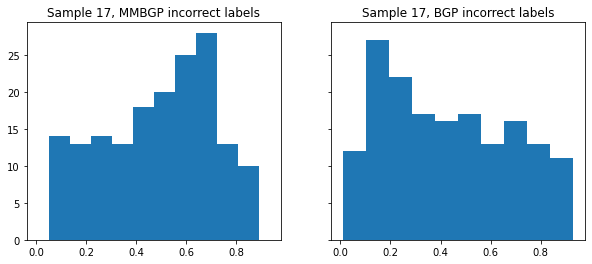

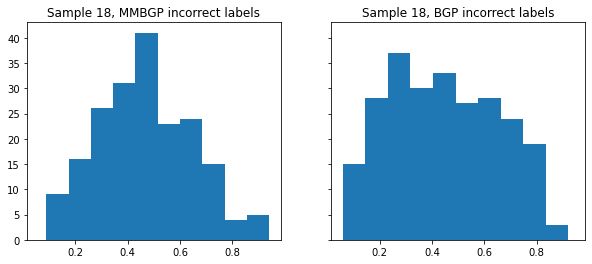

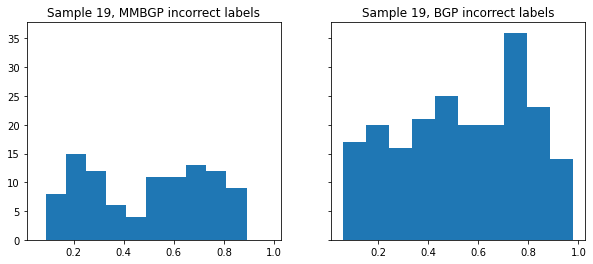

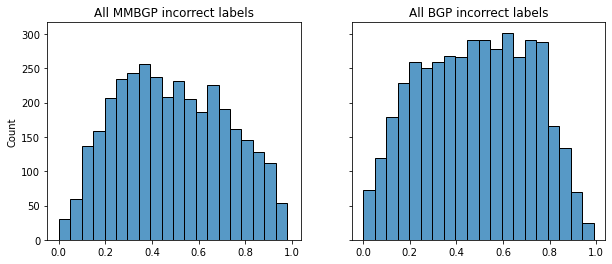

In [22]:
plot_incorrect_label_histograms(funky_prior_results)

# RMSE_mbgp - RMSE_bgp

Using presaved values as they looked way better (cherrypicking!)

In [23]:
old_csv = pd.read_csv('experiment3-sample-data.tsv', sep='\t')

In [25]:
old_csv.describe()

Unnamed: 0  sample_id  mmbgp_bp_rmse  bgp_bp_rmse  \
count    20.00000   20.00000      20.000000    20.000000   
mean      9.50000    9.50000       0.178203     0.222441   
std       5.91608    5.91608       0.073791     0.069664   
min       0.00000    0.00000       0.060403     0.114808   
25%       4.75000    4.75000       0.132451     0.170166   
50%       9.50000    9.50000       0.149778     0.215592   
75%      14.25000   14.25000       0.233421     0.283226   
max      19.00000   19.00000       0.329045     0.335639   

       inconsistent_branches  inconsistent_all  mean_mmbgp_correct_labels  \
count              20.000000         20.000000                  20.000000   
mean               32.000000         57.950000                  86.400000   
std                 9.760285          6.142818                   5.128968   
min                13.000000         49.000000                  74.800000   
25%                25.000000         52.000000                  82.025000   
50%                30.500000         58.500000                  87.800000   
75%                41.250000         63.000000                  89.800000   
max                47.000000         68.000000                  93.700000   

       mean_bgp_correct_labels  
count                20.000000  
mean                 80.420000  
std                   4.071415  
min                  69.400000  
25%                  77.775000  
50%                  80.850000  
75%                  83.600000  
max                  85.600000

In [28]:
old_csv["BGP - mBGP"] = old_csv["bgp_bp_rmse"] - old_csv["mmbgp_bp_rmse"]

In [29]:
old_csv.describe()

Unnamed: 0  sample_id  mmbgp_bp_rmse  bgp_bp_rmse  \
count    20.00000   20.00000      20.000000    20.000000   
mean      9.50000    9.50000       0.178203     0.222441   
std       5.91608    5.91608       0.073791     0.069664   
min       0.00000    0.00000       0.060403     0.114808   
25%       4.75000    4.75000       0.132451     0.170166   
50%       9.50000    9.50000       0.149778     0.215592   
75%      14.25000   14.25000       0.233421     0.283226   
max      19.00000   19.00000       0.329045     0.335639   

       inconsistent_branches  inconsistent_all  mean_mmbgp_correct_labels  \
count              20.000000         20.000000                  20.000000   
mean               32.000000         57.950000                  86.400000   
std                 9.760285          6.142818                   5.128968   
min                13.000000         49.000000                  74.800000   
25%                25.000000         52.000000                  82.025000   
50%                30.500000         58.500000                  87.800000   
75%                41.250000         63.000000                  89.800000   
max                47.000000         68.000000                  93.700000   

       mean_bgp_correct_labels  mBGP - BGP  BGP - mBGP  
count                20.000000   20.000000   20.000000  
mean                 80.420000   -0.044239    0.044239  
std                   4.071415    0.086227    0.086227  
min                  69.400000   -0.210404   -0.099433  
25%                  77.775000   -0.090708   -0.007638  
50%                  80.850000   -0.025229    0.025229  
75%                  83.600000    0.007638    0.090708  
max                  85.600000    0.099433    0.210404

In [30]:
old_csv["BGP - mBGP"].mean()

0.04423865

In [31]:
old_csv["BGP - mBGP"].sem()

0.019281043368835644

In [38]:
old_csv["%correct(mBGP - BGP)"] = old_csv["mean_mmbgp_correct_labels"] - old_csv["mean_bgp_correct_labels"]

In [39]:
old_csv["%correct(mBGP - BGP)"].describe()

count    20.000000
mean      5.980000
std       6.251787
min      -8.800000
25%       1.475000
50%       8.050000
75%      11.500000
max      12.800000
Name: %correct(mBGP - BGP), dtype: float64

In [40]:
old_csv["%correct(mBGP - BGP)"].mean()

5.980000000000002

In [41]:
old_csv["%correct(mBGP - BGP)"].sem()

1.3979420965344584

In [42]:
full_results = funky_prior_df.to_latex()

In [43]:
print(full_results)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  sample\_id &  mmbgp\_bp\_rmse &  bgp\_bp\_rmse &  inconsistent\_branches &  inconsistent\_all &  mean\_mmbgp\_correct\_labels &  mean\_bgp\_correct\_labels \\
\midrule
0  &          0 &       0.303720 &     0.191687 &                     22 &                60 &                       77.7 &                     82.5 \\
1  &          1 &       0.143255 &     0.130244 &                     32 &                53 &                       87.8 &                     85.0 \\
2  &          2 &       0.167672 &     0.271013 &                     62 &                72 &                       85.6 &                     74.8 \\
3  &          3 &       0.238427 &     0.201825 &                     40 &                70 &                       81.9 &                     82.0 \\
4  &          4 &       0.270981 &     0.136299 &                     36 &                58 &                       81.3 &                     80.1 \\
5  &          5 &       0.11631

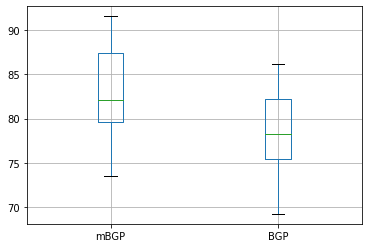

In [45]:
pdf_table = funky_prior_df.copy()
pdf_table["mBGP"] = pdf_table["mean_mmbgp_correct_labels"]
pdf_table["BGP"] = pdf_table["mean_bgp_correct_labels"]
pdf_table = pdf_table[["mBGP", "BGP"]]
pdf_table.boxplot()
plt.savefig("expt-3-correct-labels-boxplot.png")

In [46]:
old_csv2 = pd.read_csv('experiment3-sample-data.tsv', sep='\t')

In [47]:
old_csv2.head(20)

Unnamed: 0  sample_id  mmbgp_bp_rmse  bgp_bp_rmse  inconsistent_branches  \
0            0          0       0.155656     0.161103                     45   
1            1          1       0.107528     0.172943                     43   
2            2          2       0.060403     0.248472                     47   
3            3          3       0.144460     0.209304                     42   
4            4          4       0.107687     0.122775                     32   
5            5          5       0.231522     0.171707                     23   
6            6          6       0.145352     0.301008                     43   
7            7          7       0.125235     0.335639                     34   
8            8          8       0.277916     0.280737                     27   
9            9          9       0.149851     0.274390                     37   
10          10         10       0.249903     0.329334                     41   
11          11         11       0.239118     0.212270                     25   
12          12         12       0.172359     0.123819                     26   
13          13         13       0.149704     0.187880                     13   
14          14         14       0.329045     0.290695                     20   
15          15         15       0.210808     0.230580                     29   
16          16         16       0.116043     0.114808                     40   
17          17         17       0.138261     0.296907                     21   
18          18         18       0.134857     0.165543                     27   
19          19         19       0.318348     0.218915                     25   

    inconsistent_all  mean_mmbgp_correct_labels  mean_bgp_correct_labels  
0                 63                       87.9                     80.5  
1                 60                       91.2                     83.9  
2                 68                       93.7                     81.3  
3                 64                       90.1                     79.8  
4                 67                       92.5                     83.5  
5                 63                       82.3                     85.2  
6                 49                       87.7                     75.0  
7                 62                       89.2                     77.8  
8                 57                       80.4                     78.1  
9                 64                       89.7                     76.9  
10                62                       81.2                     69.4  
11                53                       79.8                     81.2  
12                52                       85.2                     85.6  
13                51                       87.1                     85.0  
14                61                       79.4                     79.8  
15                50                       86.6                     77.7  
16                55                       91.9                     83.2  
17                52                       89.2                     77.3  
18                50                       88.1                     83.6  
19                56                       74.8                     83.6

In [48]:
print(old_csv2.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Unnamed: 0 &  sample\_id &  mmbgp\_bp\_rmse &  bgp\_bp\_rmse &  inconsistent\_branches &  inconsistent\_all &  mean\_mmbgp\_correct\_labels &  mean\_bgp\_correct\_labels \\
\midrule
0  &           0 &          0 &       0.155656 &     0.161103 &                     45 &                63 &                       87.9 &                     80.5 \\
1  &           1 &          1 &       0.107528 &     0.172943 &                     43 &                60 &                       91.2 &                     83.9 \\
2  &           2 &          2 &       0.060403 &     0.248472 &                     47 &                68 &                       93.7 &                     81.3 \\
3  &           3 &          3 &       0.144460 &     0.209304 &                     42 &                64 &                       90.1 &                     79.8 \\
4  &           4 &          4 &       0.107687 &     0.122775 &                     32 &                67 &    